In [ ]:
import pandas as pd
import numpy as np
import openai
from textblob import TextBlob
import os
import re
import requests
import base64
import json
import tweepy
from textblob import TextBlob
from datetime import datetime, date
import snscrape.modules.twitter as sntwitter
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import spacy
import emoji

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk, wsd
from collections import Counter

# Transformers
from transformers import BertTokenizer, BertTokenizerFast
from transformers import TFBertModel

# tensorflow
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, save_model, load_model
from keras.layers import Embedding, LSTM, Dense

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.regularizers import l2

import optuna

# scikit-learn
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# resampling
from imblearn.over_sampling import RandomOverSampler

# workoing with emoji
from emoji import demojize

import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [ ]:
df = pd.read_csv("/data/merged_data.csv")

In [ ]:
df.head()

,Chat
0,RT @Christiann_17: Y'all really trynna kill us...
1,Done! 😊
2,RT @lucyhale: ruby woo 💄 https://t.co/xagjLPciyK
3,RT @RootToRiseHol: FEATHER EARRINGS FOR FREE S...
4,RT @isexlovve: Follow 👣👣👣👣👣👣\n👉 @Stellar_kl ht...


In [ ]:
df.shape

(10244, 1)

In [ ]:

df = df.drop_duplicates()

In [ ]:
df.shape

(9883, 1)

# Exploratory Data Analysis (EDA)

In [ ]:
def convert_emoji(text_):
    try:
        text_ = emoji.demojize(text_)
        text_ = text_.replace(":", "")
        text_ = text_.replace("_", " ")
        return text_
    except:
        return text_

In [ ]:


def clean_text(text_: str):
    try:
        text_ = re.sub('http\S+', '', text_)
        text_ = re.sub('@\S+', '', text_)
        text_ = re.sub('\\n', '', text_)
        text_ = text_.replace("RT ", "").strip()
        text_ = convert_emoji(text_)  # Define or import the `convert_emoji` function
        text_ = re.sub(r'[^\w\s]', ' ', text_)  # Remove non-alphanumeric characters
        text_ = re.sub(r'\s+', ' ', text_).strip()  # Remove extra whitespaces

        return text_
    except Exception as error:
        return text_

In [ ]:
df["clean_text"] = df["Chat"].apply(clean_text)

df.head()

,Chat,clean_text
0,RT @Christiann_17: Y'all really trynna kill us...,Y all really trynna kill us I mean I m still d...
1,Done! 😊,Done smiling face with smiling eyes
2,RT @lucyhale: ruby woo 💄 https://t.co/xagjLPciyK,ruby woo lipstick
3,RT @RootToRiseHol: FEATHER EARRINGS FOR FREE S...,FEATHER EARRINGS FOR FREE SPIRITS blue heart
4,RT @isexlovve: Follow 👣👣👣👣👣👣\n👉 @Stellar_kl ht...,Follow footprintsfootprintsfootprintsfootprint...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9883 entries, 0 to 10243
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Chat        9882 non-null   object
 1   clean_text  9882 non-null   object
dtypes: object(2)
memory usage: 231.6+ KB


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def build_corpus(data:pd.DataFrame, col_name:str="clean_text"):
    corpus = []
    wordLem = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    new_data = data[col_name].dropna().str.split()
    new_data = new_data.values.tolist()
    for i in new_data:
        for word in i:
            if word not in stop_words:
                corpus.append(wordLem.lemmatize(str(word).lower()))

    return corpus

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
corpus = build_corpus(df)

In [ ]:
counter = Counter(corpus)
top_words = counter.most_common()

In [ ]:
# top_words

In [ ]:
plot_x = []
plot_y = []

for word, count in top_words[:20]:
    if word not in stop_words:
        plot_x.append(word)
        plot_y.append(count)

## Highest occuring words

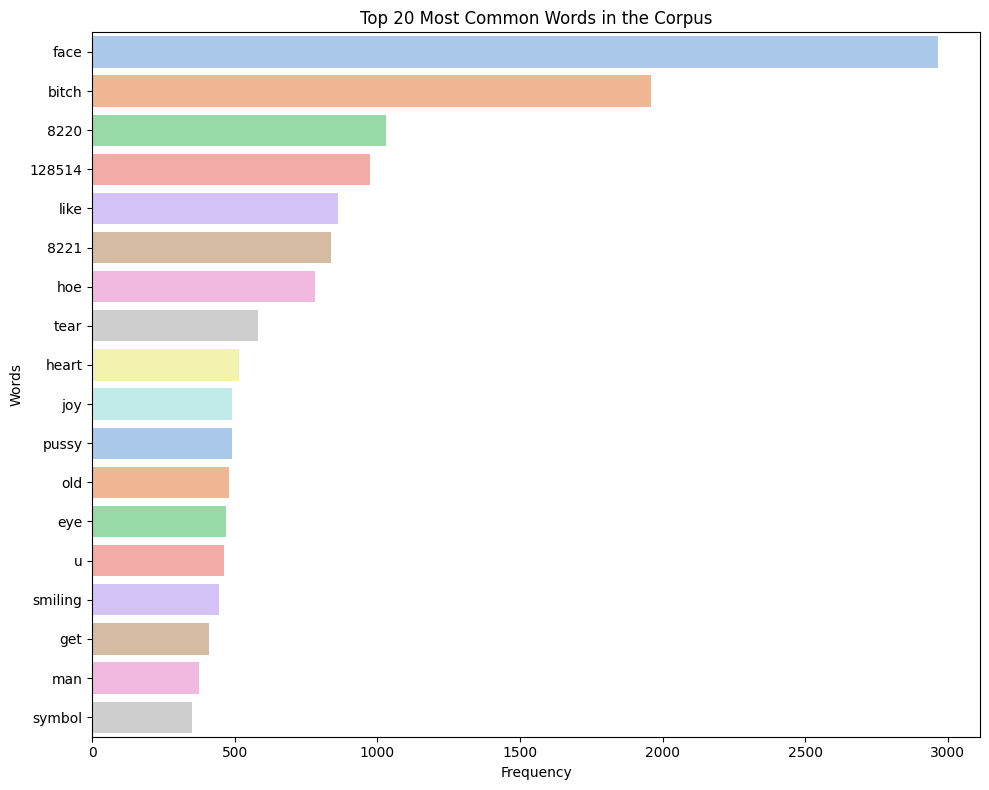

In [ ]:
# sns.set_theme(style="darkgrid", palette="pastel")
plt.figure(figsize=(10,8))
sns.barplot(x=plot_y, y=plot_x, palette="pastel", order=plot_x)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in the Corpus")
plt.tight_layout()
plt.show()

## Wordcloud


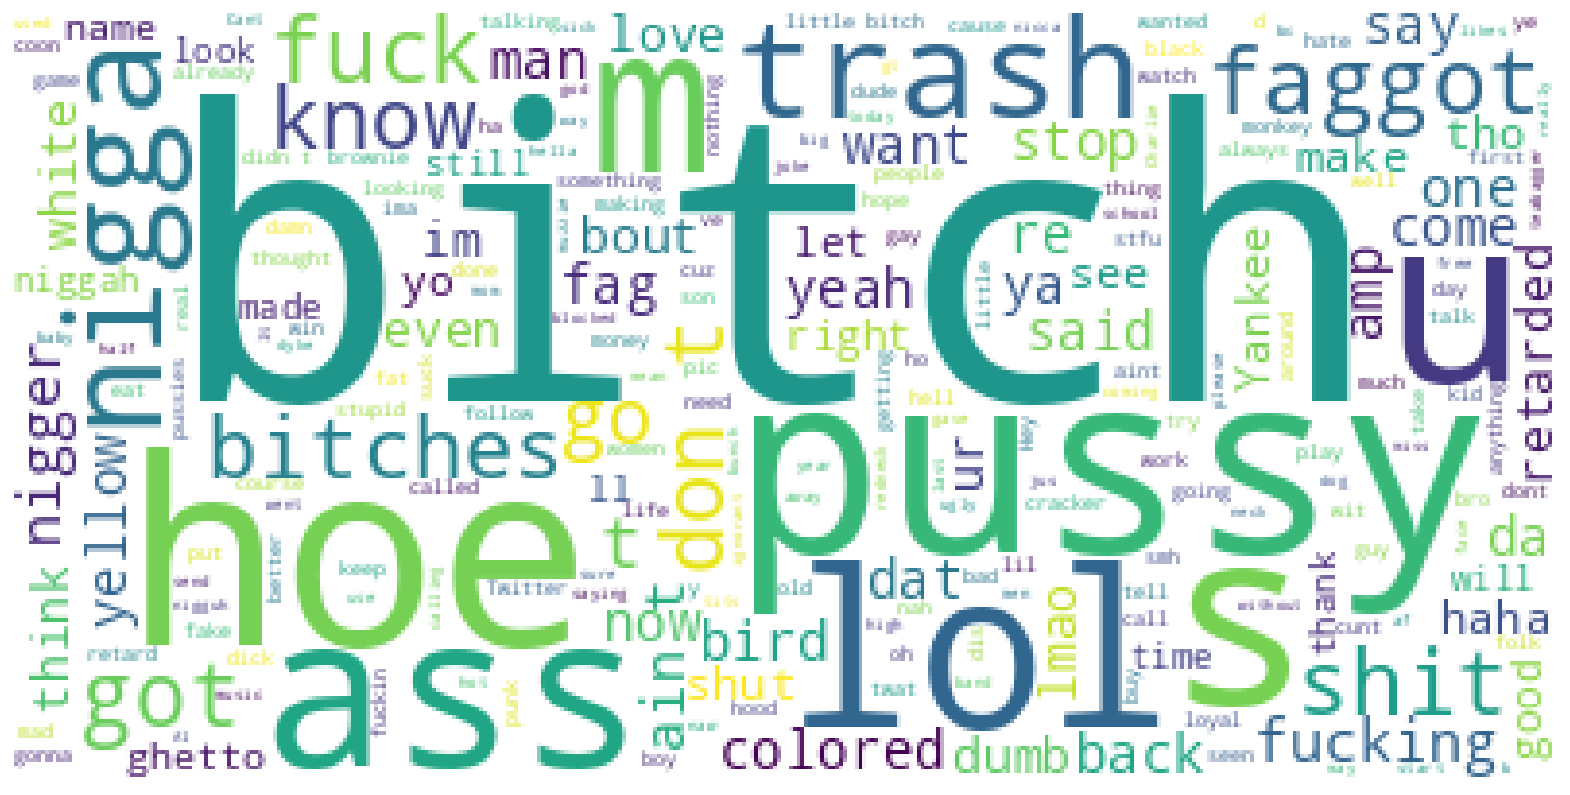

In [ ]:
plt.figure(figsize=(20,15))

plt_wordcloud = WordCloud(max_words=1000, stopwords=STOPWORDS, background_color='white').generate(" ".join(list(df.clean_text.values)[-1000:-300]))
plt.imshow(plt_wordcloud)
plt.axis('off')
plt.show()

## Frequently occuring

In [ ]:
frequent_words = df.clean_text.str.split(expand=True).stack().value_counts()
top_frequent_words = frequent_words[:50]

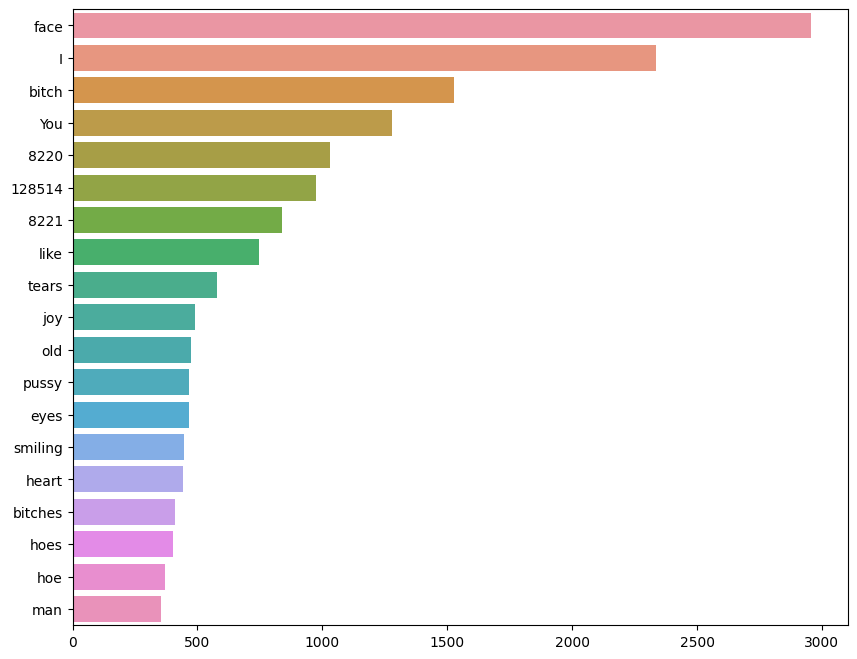

In [ ]:
plot_x = []
plot_y = []

for i, x in enumerate(top_frequent_words.keys()):
    if x not in stop_words:
        plot_x.append(top_frequent_words.keys()[i])
        plot_y.append(top_frequent_words[i])

plt.figure(figsize=(10,8))
sns.barplot(x=plot_y, y=plot_x)
plt.show()

In [ ]:
fig = px.treemap(top_frequent_words, path=[top_frequent_words.index], values=0)

fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

# Tokenization

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df["clean_text"] = df["clean_text"].astype("str")
df["Tokens"] = df["clean_text"].apply(word_tokenize)
df.head()

,Chat,clean_text,Tokens
0,RT @Christiann_17: Y'all really trynna kill us...,Y all really trynna kill us I mean I m still d...,"[Y, all, really, trynna, kill, us, I, mean, I,..."
1,Done! 😊,Done smiling face with smiling eyes,"[Done, smiling, face, with, smiling, eyes]"
2,RT @lucyhale: ruby woo 💄 https://t.co/xagjLPciyK,ruby woo lipstick,"[ruby, woo, lipstick]"
3,RT @RootToRiseHol: FEATHER EARRINGS FOR FREE S...,FEATHER EARRINGS FOR FREE SPIRITS blue heart,"[FEATHER, EARRINGS, FOR, FREE, SPIRITS, blue, ..."
4,RT @isexlovve: Follow 👣👣👣👣👣👣\n👉 @Stellar_kl ht...,Follow footprintsfootprintsfootprintsfootprint...,"[Follow, footprintsfootprintsfootprintsfootpri..."


In [ ]:
# word distribution for the tokenized data
word_len = df["Tokens"].apply(lambda x: [len(word) for word in x])
word_len = [len_ for sublist in word_len for len_ in sublist]
word_len_sort = sorted(word_len, reverse=True)

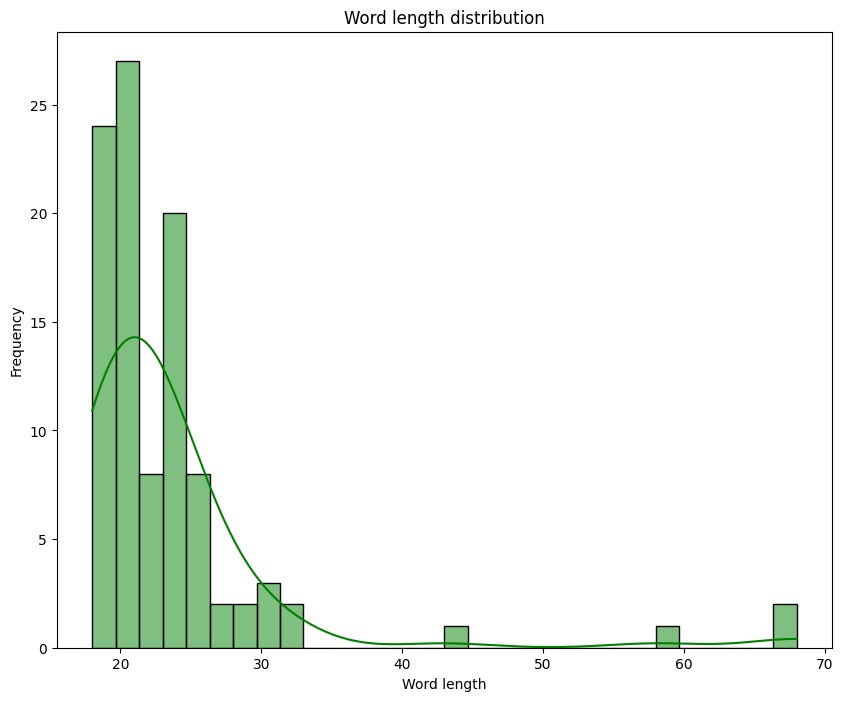

In [ ]:
plt.figure(figsize=(10,8))
sns.histplot(word_len_sort[:100], kde=True, color='green')
plt.title("Word length distribution")
plt.xlabel("Word length")
plt.ylabel("Frequency")
plt.show()

# Part of speech tagging

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
df["POS"] = df["Tokens"].apply(pos_tag)

In [ ]:
df.head()

,Chat,clean_text,Tokens,POS
0,RT @Christiann_17: Y'all really trynna kill us...,Y all really trynna kill us I mean I m still d...,"[Y, all, really, trynna, kill, us, I, mean, I,...","[(Y, NNP), (all, DT), (really, RB), (trynna, J..."
1,Done! 😊,Done smiling face with smiling eyes,"[Done, smiling, face, with, smiling, eyes]","[(Done, CD), (smiling, VBG), (face, NN), (with..."
2,RT @lucyhale: ruby woo 💄 https://t.co/xagjLPciyK,ruby woo lipstick,"[ruby, woo, lipstick]","[(ruby, NN), (woo, NN), (lipstick, NN)]"
3,RT @RootToRiseHol: FEATHER EARRINGS FOR FREE S...,FEATHER EARRINGS FOR FREE SPIRITS blue heart,"[FEATHER, EARRINGS, FOR, FREE, SPIRITS, blue, ...","[(FEATHER, NNP), (EARRINGS, NNP), (FOR, NNP), ..."
4,RT @isexlovve: Follow 👣👣👣👣👣👣\n👉 @Stellar_kl ht...,Follow footprintsfootprintsfootprintsfootprint...,"[Follow, footprintsfootprintsfootprintsfootpri...","[(Follow, NNP), (footprintsfootprintsfootprint..."


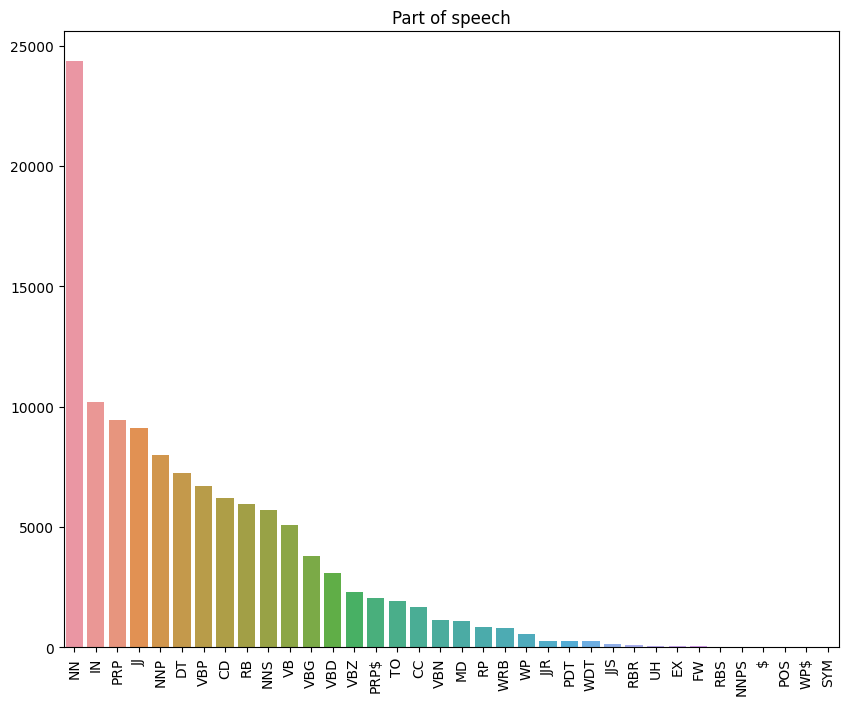

In [ ]:
pos_counts = {}
for pos in df['POS']:
    for index, ps in pos:
        if ps in pos_counts:
            pos_counts[ps] += 1
        else:
            pos_counts[ps] = 1

# Sort the dictionary by values in descending order
sorted_pos_counts = {k: v for k, v in sorted(pos_counts.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(10, 8))
sns.barplot(x=list(sorted_pos_counts.keys()), y=list(sorted_pos_counts.values()))
plt.title("Part of speech")
plt.xticks(rotation=90)
plt.show()

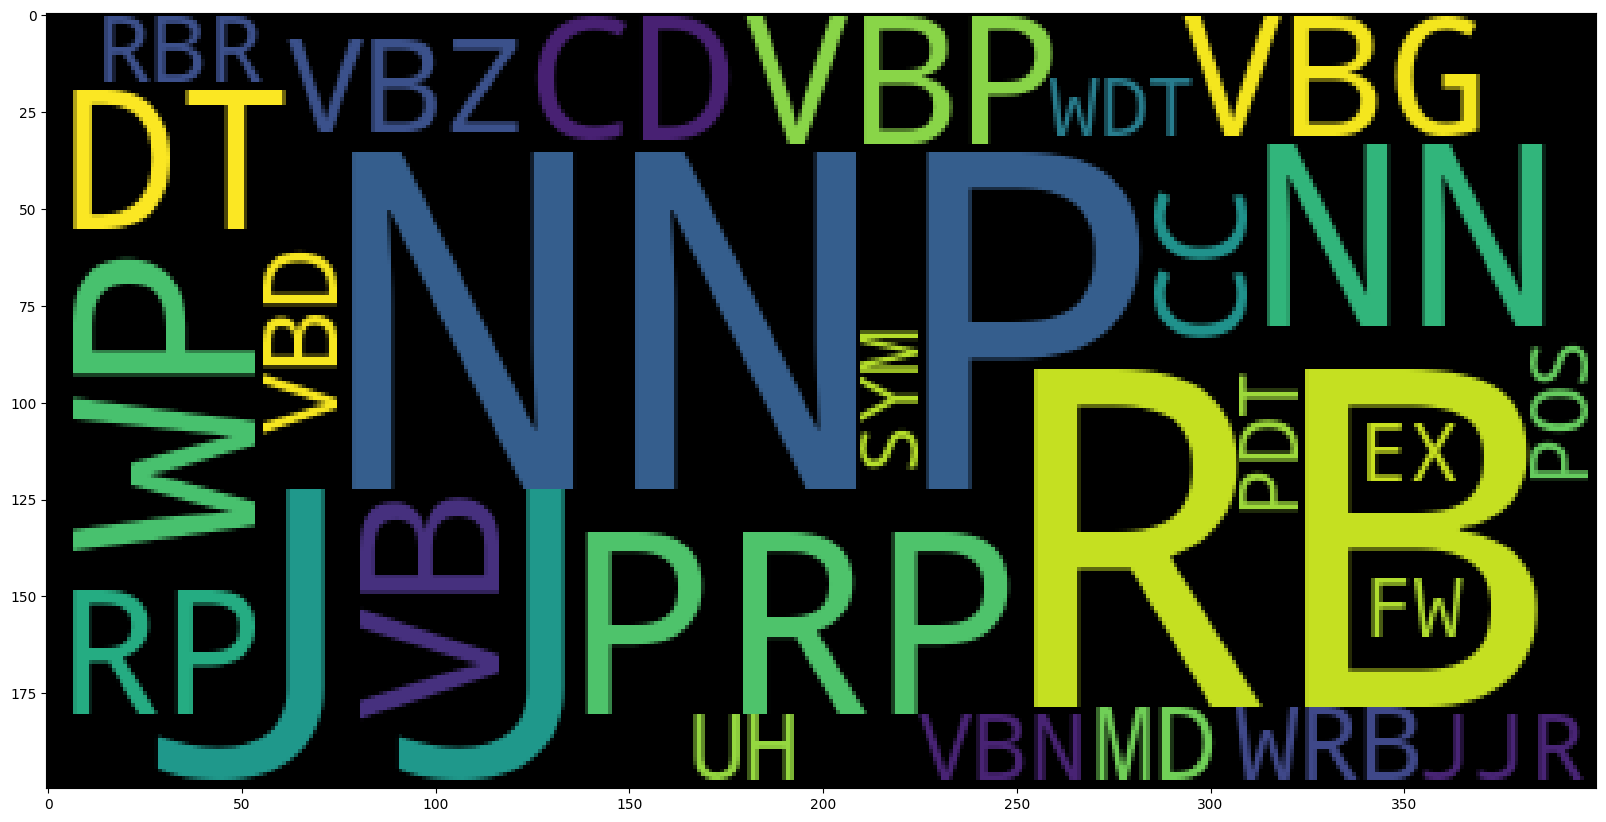

In [ ]:
plt.figure(figsize=(20,15))

pos_wordcloud = WordCloud(max_words=1000).generate(" ".join(list(pos_counts.keys())))
plt.imshow(pos_wordcloud)

# Sentiment Analysis

In [ ]:
# effect of emoji on sentiment analysis

text_with_emoji = TextBlob("😠").sentiment.polarity
text_with_conv_emoji = TextBlob(convert_emoji("😠")).sentiment.polarity

print("This emoji is compared with hashcode and text-converted: 😠 \n")
print("Sentiment for normal emoji hashcode => ", text_with_emoji)
print("Sentiment for emoji converted to text => ", text_with_conv_emoji)

print("\nThis shows that emojis, when converted to textual form, adds to the sentiment value")

This emoji is compared with hashcode and text-converted: 😠 

Sentiment for normal emoji hashcode =>  0.0
Sentiment for emoji converted to text =>  -0.5

This shows that emojis, when converted to textual form, adds to the sentiment value


In [ ]:
# converting emojis to textual form
df["clean_text"] = df["clean_text"].apply(convert_emoji)

In [ ]:
df["Sentiment"] = df["clean_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
df.head()

,Chat,clean_text,Tokens,POS,Sentiment
0,RT @Christiann_17: Y'all really trynna kill us...,Y all really trynna kill us I mean I m still d...,"[Y, all, really, trynna, kill, us, I, mean, I,...","[(Y, NNP), (all, DT), (really, RB), (trynna, J...",-0.089352
1,Done! 😊,Done smiling face with smiling eyes,"[Done, smiling, face, with, smiling, eyes]","[(Done, CD), (smiling, VBG), (face, NN), (with...",0.000000
2,RT @lucyhale: ruby woo 💄 https://t.co/xagjLPciyK,ruby woo lipstick,"[ruby, woo, lipstick]","[(ruby, NN), (woo, NN), (lipstick, NN)]",0.000000
3,RT @RootToRiseHol: FEATHER EARRINGS FOR FREE S...,FEATHER EARRINGS FOR FREE SPIRITS blue heart,"[FEATHER, EARRINGS, FOR, FREE, SPIRITS, blue, ...","[(FEATHER, NNP), (EARRINGS, NNP), (FOR, NNP), ...",0.200000
4,RT @isexlovve: Follow 👣👣👣👣👣👣\n👉 @Stellar_kl ht...,Follow footprintsfootprintsfootprintsfootprint...,"[Follow, footprintsfootprintsfootprintsfootpri...","[(Follow, NNP), (footprintsfootprintsfootprint...",0.285714


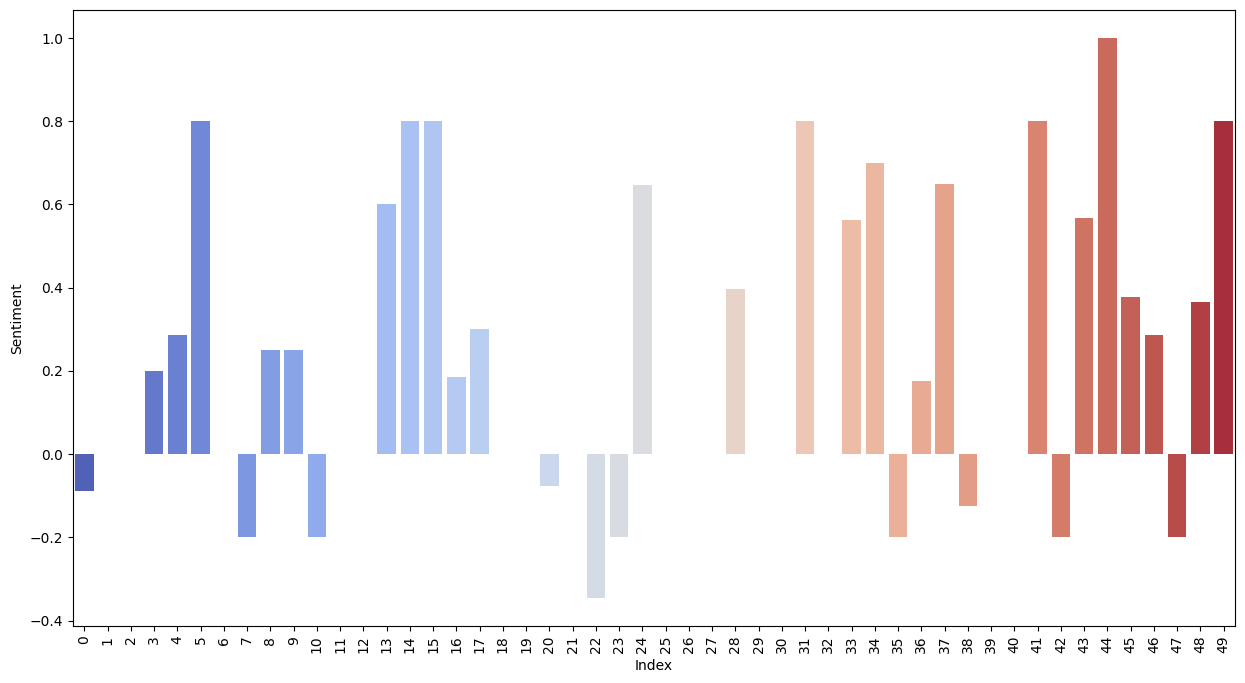

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x=df.index[:50], y=df["Sentiment"][:50], palette="coolwarm")

plt.xticks(rotation=90)
plt.xlabel('Index')
plt.show()

# Name entity recognition

In [ ]:
import nltk
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [ ]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
df["NER"] = df["POS"].apply(ne_chunk)

In [ ]:
df.head(5)

,Chat,clean_text,Tokens,POS,Sentiment,NER
0,RT @Christiann_17: Y'all really trynna kill us...,Y all really trynna kill us I mean I m still d...,"[Y, all, really, trynna, kill, us, I, mean, I,...","[(Y, NNP), (all, DT), (really, RB), (trynna, J...",-0.089352,"[(Y, NNP), (all, DT), (really, RB), (trynna, J..."
1,Done! 😊,Done smiling face with smiling eyes,"[Done, smiling, face, with, smiling, eyes]","[(Done, CD), (smiling, VBG), (face, NN), (with...",0.000000,"[(Done, CD), (smiling, VBG), (face, NN), (with..."
2,RT @lucyhale: ruby woo 💄 https://t.co/xagjLPciyK,ruby woo lipstick,"[ruby, woo, lipstick]","[(ruby, NN), (woo, NN), (lipstick, NN)]",0.000000,"[(ruby, NN), (woo, NN), (lipstick, NN)]"
3,RT @RootToRiseHol: FEATHER EARRINGS FOR FREE S...,FEATHER EARRINGS FOR FREE SPIRITS blue heart,"[FEATHER, EARRINGS, FOR, FREE, SPIRITS, blue, ...","[(FEATHER, NNP), (EARRINGS, NNP), (FOR, NNP), ...",0.200000,"[(FEATHER, NNP), [(EARRINGS, NNP), (FOR, NNP)]..."
4,RT @isexlovve: Follow 👣👣👣👣👣👣\n👉 @Stellar_kl ht...,Follow footprintsfootprintsfootprintsfootprint...,"[Follow, footprintsfootprintsfootprintsfootpri...","[(Follow, NNP), (footprintsfootprintsfootprint...",0.285714,"[[(Follow, NNP)], (footprintsfootprintsfootpri..."


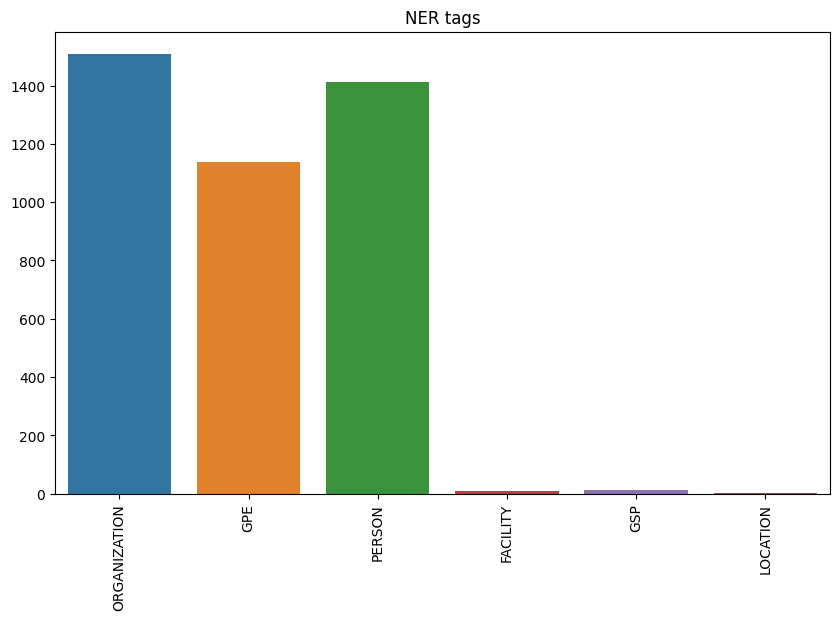

In [ ]:
ner_counts = {}
for ner_ in df['NER']:
    for ns in ner_:
        if hasattr(ns, 'label'):
            ner_tag = ns.label()
            if ner_tag in ner_counts:
                ner_counts[ner_tag] += 1
            else:
                ner_counts[ner_tag] = 1

plt.figure(figsize=(10,6))
sns.barplot(x=list(ner_counts.keys()), y=list(ner_counts.values()))
plt.title("NER tags")
plt.xticks(rotation=90)
plt.show()

# Word sense disambiguation

In [ ]:
def wsd_create(text_list):
    wsd_tokens = []
    for token in text_list:
        wsdata = wsd.lesk(text_list, token)
        if wsdata:
            wsd_tokens.append(wsdata.name())
        else:
            wsd_tokens.append(None)
    return wsd_tokens

In [ ]:
df["WSD"] = df["Tokens"].apply(wsd_create)

In [ ]:
df.head()

,Chat,clean_text,Tokens,POS,Sentiment,NER,WSD
0,RT @Christiann_17: Y'all really trynna kill us...,Y all really trynna kill us I mean I m still d...,"[Y, all, really, trynna, kill, us, I, mean, I,...","[(Y, NNP), (all, DT), (really, RB), (trynna, J...",-0.089352,"[(Y, NNP), (all, DT), (really, RB), (trynna, J...","[yttrium.n.01, wholly.r.01, very.r.01, None, t..."
1,Done! 😊,Done smiling face with smiling eyes,"[Done, smiling, face, with, smiling, eyes]","[(Done, CD), (smiling, VBG), (face, NN), (with...",0.000000,"[(Done, CD), (smiling, VBG), (face, NN), (with...","[suffice.v.01, beamish.s.01, front.v.01, None,..."
2,RT @lucyhale: ruby woo 💄 https://t.co/xagjLPciyK,ruby woo lipstick,"[ruby, woo, lipstick]","[(ruby, NN), (woo, NN), (lipstick, NN)]",0.000000,"[(ruby, NN), (woo, NN), (lipstick, NN)]","[ruby.n.01, woo.v.02, lipstick.v.02]"
3,RT @RootToRiseHol: FEATHER EARRINGS FOR FREE S...,FEATHER EARRINGS FOR FREE SPIRITS blue heart,"[FEATHER, EARRINGS, FOR, FREE, SPIRITS, blue, ...","[(FEATHER, NNP), (EARRINGS, NNP), (FOR, NNP), ...",0.200000,"[(FEATHER, NNP), [(EARRINGS, NNP), (FOR, NNP)]...","[fledge.v.03, earring.n.01, None, unblock.v.03..."
4,RT @isexlovve: Follow 👣👣👣👣👣👣\n👉 @Stellar_kl ht...,Follow footprintsfootprintsfootprintsfootprint...,"[Follow, footprintsfootprintsfootprintsfootpri...","[(Follow, NNP), (footprintsfootprintsfootprint...",0.285714,"[[(Follow, NNP)], (footprintsfootprintsfootpri...","[watch.v.02, None, index.v.02, point.v.12, rig..."


# Lemmatization

In [ ]:
# initialize
lametizer = WordNetLemmatizer()
df["Lemmatize"] = df["Tokens"].apply(lambda x: [lametizer.lemmatize(token) for token in x])

In [ ]:
df.head(2)

,Chat,clean_text,Tokens,POS,Sentiment,NER,WSD,Lemmatize
0,RT @Christiann_17: Y'all really trynna kill us...,Y all really trynna kill us I mean I m still d...,"[Y, all, really, trynna, kill, us, I, mean, I,...","[(Y, NNP), (all, DT), (really, RB), (trynna, J...",-0.089352,"[(Y, NNP), (all, DT), (really, RB), (trynna, J...","[yttrium.n.01, wholly.r.01, very.r.01, None, t...","[Y, all, really, trynna, kill, u, I, mean, I, ..."
1,Done! 😊,Done smiling face with smiling eyes,"[Done, smiling, face, with, smiling, eyes]","[(Done, CD), (smiling, VBG), (face, NN), (with...",0.000000,"[(Done, CD), (smiling, VBG), (face, NN), (with...","[suffice.v.01, beamish.s.01, front.v.01, None,...","[Done, smiling, face, with, smiling, eye]"


# Parsing

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def perform_parsed(text_):
    doc = nlp(text_)
    parsed_res = []
    for token in doc:
        data_ = (token.text, token.pos_, token.dep_, token.head.text)
        parsed_res.append(data_)
    return parsed_res

df["Parsed text"] = df["clean_text"].apply(perform_parsed)

In [ ]:
df.head(2)

,Chat,clean_text,Tokens,POS,Sentiment,NER,WSD,Lemmatize,Parsed text
0,RT @Christiann_17: Y'all really trynna kill us...,Y all really trynna kill us I mean I m still d...,"[Y, all, really, trynna, kill, us, I, mean, I,...","[(Y, NNP), (all, DT), (really, RB), (trynna, J...",-0.089352,"[(Y, NNP), (all, DT), (really, RB), (trynna, J...","[yttrium.n.01, wholly.r.01, very.r.01, None, t...","[Y, all, really, trynna, kill, u, I, mean, I, ...","[(Y, PROPN, nsubj, kill), (all, PRON, appos, Y..."
1,Done! 😊,Done smiling face with smiling eyes,"[Done, smiling, face, with, smiling, eyes]","[(Done, CD), (smiling, VBG), (face, NN), (with...",0.000000,"[(Done, CD), (smiling, VBG), (face, NN), (with...","[suffice.v.01, beamish.s.01, front.v.01, None,...","[Done, smiling, face, with, smiling, eye]","[(Done, VERB, ROOT, Done), (smiling, VERB, amo..."


# Check number of words

In [ ]:
def check_text_len(txt):
    try:
        return len(txt.split())
    except:
        return 0

df['text_len'] = df['clean_text'].apply(check_text_len)

In [ ]:
df.head(2)

,Chat,clean_text,Tokens,POS,Sentiment,NER,WSD,Lemmatize,Parsed text,text_len
0,RT @Christiann_17: Y'all really trynna kill us...,Y all really trynna kill us I mean I m still d...,"[Y, all, really, trynna, kill, us, I, mean, I,...","[(Y, NNP), (all, DT), (really, RB), (trynna, J...",-0.089352,"[(Y, NNP), (all, DT), (really, RB), (trynna, J...","[yttrium.n.01, wholly.r.01, very.r.01, None, t...","[Y, all, really, trynna, kill, u, I, mean, I, ...","[(Y, PROPN, nsubj, kill), (all, PRON, appos, Y...",13
1,Done! 😊,Done smiling face with smiling eyes,"[Done, smiling, face, with, smiling, eyes]","[(Done, CD), (smiling, VBG), (face, NN), (with...",0.000000,"[(Done, CD), (smiling, VBG), (face, NN), (with...","[suffice.v.01, beamish.s.01, front.v.01, None,...","[Done, smiling, face, with, smiling, eye]","[(Done, VERB, ROOT, Done), (smiling, VERB, amo...",6


In [ ]:
max_token_length = df['text_len'].max()
print("Highest token length:", max_token_length)

Highest token length: 75


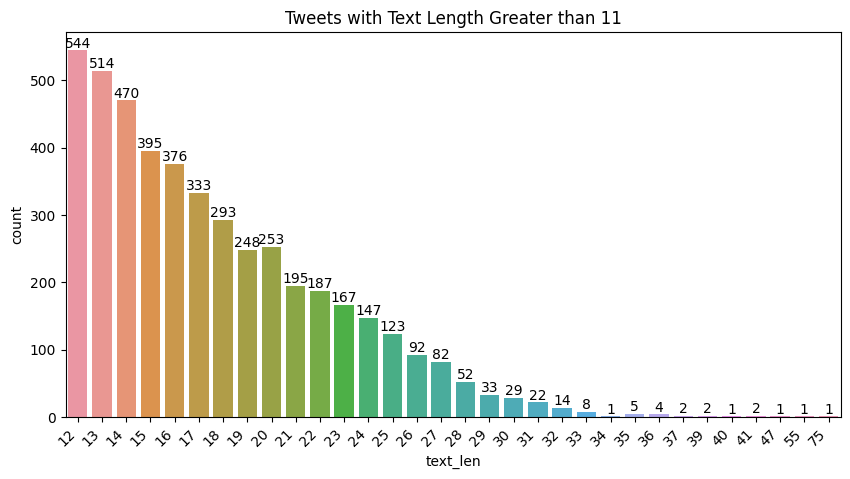

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
axes = sns.countplot(x='text_len', data=df[df['text_len'] > 11])
plt.title("Tweets with Text Length Greater than 11")
axes.bar_label(axes.containers[0])

# Adjust x-axis ticks and labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


# Further cleaning and tokenization

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
def check_token_len(txt):
    global tokenizer
    try:
        text_token = len(tokenizer.encode(txt, max_length=512, truncation=True, padding=True))
        return text_token
    except:
        return 0

df["token_len"] = df["clean_text"].apply(check_token_len)

In [ ]:
df.token_len.max(), df.token_len.min()

(200, 2)

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head(2)

,Chat,clean_text,Tokens,POS,Sentiment,NER,WSD,Lemmatize,Parsed text,text_len,token_len
0,&#8220;@Xenoss_: ''single af'' we don't care y...,8220 single af we don t care you re ugly anywa...,"[8220, single, af, we, don, t, care, you, re, ...","[(8220, CD), (single, JJ), (af, NN), (we, PRP)...",-0.385714,"[(8220, CD), (single, JJ), (af, NN), (we, PRP)...","[None, single.v.01, None, None, wear.v.09, tri...","[8220, single, af, we, don, t, care, you, re, ...","[(8220, NUM, nummod, don), (single, ADJ, amod,...",14,19
1,&#8220;@ThatDamnTwerk1 Beef is when a bitch ti...,8220 Beef is when a bitch titties looking like...,"[8220, Beef, is, when, a, bitch, titties, look...","[(8220, CD), (Beef, NNP), (is, VBZ), (when, WR...",0.000000,"[(8220, CD), (Beef, NNP), (is, VBZ), (when, WR...","[None, gripe.v.01, embody.v.02, None, deoxyade...","[8220, Beef, is, when, a, bitch, titty, lookin...","[(8220, NUM, nummod, Beef), (Beef, PROPN, nsub...",15,21


In [ ]:
# Catergorize the sentiment column
def sentiment_categorizer(sentiment_):
    if sentiment_ > 0:
        return 'Positive'
    elif sentiment_ < 0:
        return 'Negative'
    else:
        return 'Neutral'

df["Sentiment_cat"] = df["Sentiment"].apply(sentiment_categorizer)

In [ ]:
print(df["Sentiment_cat"].value_counts())

Neutral     3837
Positive    3587
Negative    2459
Name: Sentiment_cat, dtype: int64


Pie chart of sentiment category


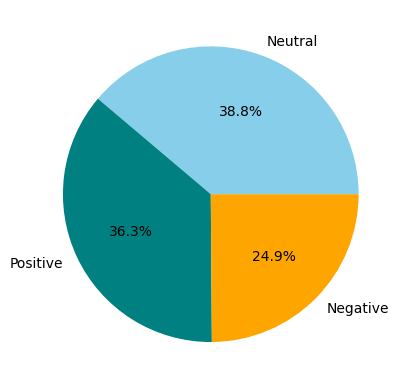

In [ ]:
print("Pie chart of sentiment category")
plt.pie(df["Sentiment_cat"].value_counts(), labels=["Neutral", "Positive", "Negative"], colors=["skyblue", "teal", "orange"],
       autopct='%1.1f%%')

plt.show()

### Encode

In [ ]:
df["Sentiment_cat_encode"] = df["Sentiment_cat"].map({"Negative":0, "Neutral":1, "Positive":2})

# Working on imbalanced data

In [ ]:
def join_lemma(list_):
    return " ".join(list_)

df["cleant_text_lemma"] = df["Lemmatize"].apply(join_lemma)

In [ ]:
df.head(2)

,Chat,clean_text,Tokens,POS,Sentiment,NER,WSD,Lemmatize,Parsed text,text_len,token_len,Sentiment_cat,Sentiment_cat_encode,cleant_text_lemma
0,&#8220;@Xenoss_: ''single af'' we don't care y...,8220 single af we don t care you re ugly anywa...,"[8220, single, af, we, don, t, care, you, re, ...","[(8220, CD), (single, JJ), (af, NN), (we, PRP)...",-0.385714,"[(8220, CD), (single, JJ), (af, NN), (we, PRP)...","[None, single.v.01, None, None, wear.v.09, tri...","[8220, single, af, we, don, t, care, you, re, ...","[(8220, NUM, nummod, don), (single, ADJ, amod,...",14,19,Negative,0,8220 single af we don t care you re ugly anywa...
1,&#8220;@ThatDamnTwerk1 Beef is when a bitch ti...,8220 Beef is when a bitch titties looking like...,"[8220, Beef, is, when, a, bitch, titties, look...","[(8220, CD), (Beef, NNP), (is, VBZ), (when, WR...",0.000000,"[(8220, CD), (Beef, NNP), (is, VBZ), (when, WR...","[None, gripe.v.01, embody.v.02, None, deoxyade...","[8220, Beef, is, when, a, bitch, titty, lookin...","[(8220, NUM, nummod, Beef), (Beef, PROPN, nsub...",15,21,Neutral,1,8220 Beef is when a bitch titty looking like t...


In [ ]:
df.shape

(9883, 14)

In [ ]:
rs = RandomOverSampler()

In [ ]:
x_vals = np.array(df["cleant_text_lemma"]).reshape(-1,1)
y_vals = np.array(df["Sentiment_cat_encode"]).reshape(-1,1)

data_x, data_y = rs.fit_resample(x_vals, y_vals)

In [ ]:
data_final = pd.DataFrame(list(zip([x[0] for x in data_x], data_y)), columns=["clean_text", "Sentiment"])

In [ ]:
print(df["Sentiment_cat"].value_counts())

Neutral     3837
Positive    3587
Negative    2459
Name: Sentiment_cat, dtype: int64


In [ ]:
data_final["Sentiment"].value_counts()

0    3837
1    3837
2    3837
Name: Sentiment, dtype: int64

# Train BERT

In [ ]:
MAX_LEN = df.token_len.max() + 30

# Define the `tokenize` function
def tokenize(data, max_=MAX_LEN):
    input_id = []
    attention_mask = []
    for i in range(len(data)):
        encode = tokenizer.encode_plus(data[i], max_length=max_, add_special_tokens=True,
                                       padding='max_length', return_attention_mask=True)
        input_id.append(encode["input_ids"])
        attention_mask.append(encode["attention_mask"])
    return np.array(input_id), np.array(attention_mask)

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# data preparation and splitting
X = data_final["clean_text"].values
y = data_final["Sentiment"].values

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the OneHotEncoder
one_hot = OneHotEncoder()

# Fit the encoder on the entire target variable
one_hot.fit(np.array(y_train).reshape(-1, 1))

# Transform the target variables to one-hot encoded format
y_train_onehot = one_hot.transform(np.array(y_train).reshape(-1, 1)).toarray()

In [ ]:
# Print the last few rows of the array
print("\nLast few rows:")
print(y_train_onehot[-5:])


Last few rows:
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:
# Define the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def model_builder(learning_rate, batch_size, dropout_rate, l2_reg, epochs, bert_model=bert_model, max_=MAX_LEN):
    # Optimizer with the specified learning rate
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=1e-7)

    # Categorical Crossentropy loss function
    loss = tf.keras.losses.CategoricalCrossentropy()

    # Categorical Accuracy metric
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Input layers
    input_ids = tf.keras.Input(shape=(max_,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_,), dtype='int32')

    # BERT embeddings
    embeddings = bert_model([input_ids, attention_masks])[1]

    # Additional dropout layer for regularization
    dropout = tf.keras.layers.Dropout(dropout_rate)(embeddings)

    # Dense layer with specified L2 regularization
    dense_layer = tf.keras.layers.Dense(len(one_hot.categories_[0]), activation="softmax",
                                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(dropout)

    # Build and compile the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=dense_layer)
    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])


    return model

In [ ]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)


# Define the number of epochs and other constants
final_epochs =10
fold_epochs =10
num_trials = 2

# Initialize lists to store history for all folds
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []


# Tokenize the test data
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)
y_test_onehot = one_hot.transform(np.array(y_test).reshape(-1, 1)).toarray()


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-7, 1e-5)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-4, 1e-1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)


    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    total_combined_objective = 0


    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        print(f"Fold {fold}")

        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[val_index]

        train_input_ids, train_attention_masks = tokenize(X_train_fold, MAX_LEN)
        val_input_ids, val_attention_masks = tokenize(X_val_fold, MAX_LEN)

        model = model_builder(learning_rate, batch_size, dropout_rate, l2_reg, fold_epochs, bert_model, MAX_LEN)


        history = model.fit(
        [train_input_ids, train_attention_masks],
        y_train_fold,
        validation_data=([val_input_ids, val_attention_masks], y_val_fold),
        epochs=fold_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1,
    )

    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])
    all_train_accuracy.append(history.history['categorical_accuracy'])
    all_val_accuracy.append(history.history['val_categorical_accuracy'])

    y_pred = model.predict([val_input_ids, val_attention_masks])

    micro_f1_score_value = f1_score(y_val_fold.argmax(axis=1), y_pred.argmax(axis=1), average='micro')
    micro_recall_value = recall_score(y_val_fold.argmax(axis=1), y_pred.argmax(axis=1), average='micro')
    micro_precision_value = precision_score(y_val_fold.argmax(axis=1), y_pred.argmax(axis=1), average='micro')

    combined_objective = (micro_f1_score_value + micro_recall_value + micro_precision_value) / 3.0
    total_combined_objective += combined_objective

    return total_combined_objective / 3

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=num_trials)

[I 2023-09-05 07:56:35,721] A new study created in memory with name: no-name-71b98307-da63-4d93-a29b-cc3633ae354c


Fold 1
Epoch 1/10
384/384 [==============================] - 347s 862ms/step - loss: 1.2664 - categorical_accuracy: 0.3617 - val_loss: 1.0718 - val_categorical_accuracy: 0.5055
Epoch 2/10
384/384 [==============================] - 329s 857ms/step - loss: 1.1042 - categorical_accuracy: 0.4775 - val_loss: 0.9439 - val_categorical_accuracy: 0.6117
Epoch 3/10
384/384 [==============================] - 329s 857ms/step - loss: 0.9753 - categorical_accuracy: 0.5782 - val_loss: 0.8388 - val_categorical_accuracy: 0.6733
Epoch 4/10
384/384 [==============================] - 329s 857ms/step - loss: 0.8545 - categorical_accuracy: 0.6641 - val_loss: 0.7444 - val_categorical_accuracy: 0.7140
Epoch 5/10
384/384 [==============================] - 329s 857ms/step - loss: 0.7371 - categorical_accuracy: 0.7281 - val_loss: 0.6799 - val_categorical_accuracy: 0.7508
Epoch 6/10
384/384 [==============================] - 329s 856ms/step - loss: 0.6272 - categorical_accuracy: 0.7849 - val_loss: 0.5988 - val_ca

[I 2023-09-05 10:21:08,377] Trial 0 finished with value: 0.3257304225046161 and parameters: {'learning_rate': 1.8856184884316801e-06, 'batch_size': 16, 'dropout_rate': 0.4947942702965961, 'l2_reg': 0.009512887740430732}. Best is trial 0 with value: 0.3257304225046161.


Fold 1
Epoch 1/10
768/768 [==============================] - 367s 457ms/step - loss: 0.3746 - categorical_accuracy: 0.8996 - val_loss: 0.1217 - val_categorical_accuracy: 0.9805
Epoch 2/10
768/768 [==============================] - 348s 453ms/step - loss: 0.1688 - categorical_accuracy: 0.9552 - val_loss: 0.0879 - val_categorical_accuracy: 0.9801
Epoch 3/10
768/768 [==============================] - 348s 454ms/step - loss: 0.1423 - categorical_accuracy: 0.9611 - val_loss: 0.0799 - val_categorical_accuracy: 0.9824
Epoch 4/10
768/768 [==============================] - 348s 454ms/step - loss: 0.1228 - categorical_accuracy: 0.9656 - val_loss: 0.0768 - val_categorical_accuracy: 0.9824
Epoch 5/10
768/768 [==============================] - 348s 454ms/step - loss: 0.1093 - categorical_accuracy: 0.9690 - val_loss: 0.0754 - val_categorical_accuracy: 0.9824
Epoch 6/10
768/768 [==============================] - 348s 453ms/step - loss: 0.1032 - categorical_accuracy: 0.9723 - val_loss: 0.0760 - val_ca

[I 2023-09-05 13:05:30,740] Trial 1 finished with value: 0.33105246008471817 and parameters: {'learning_rate': 4.0244594068583686e-07, 'batch_size': 8, 'dropout_rate': 0.3181170309223371, 'l2_reg': 0.00016653762587868945}. Best is trial 1 with value: 0.33105246008471817.


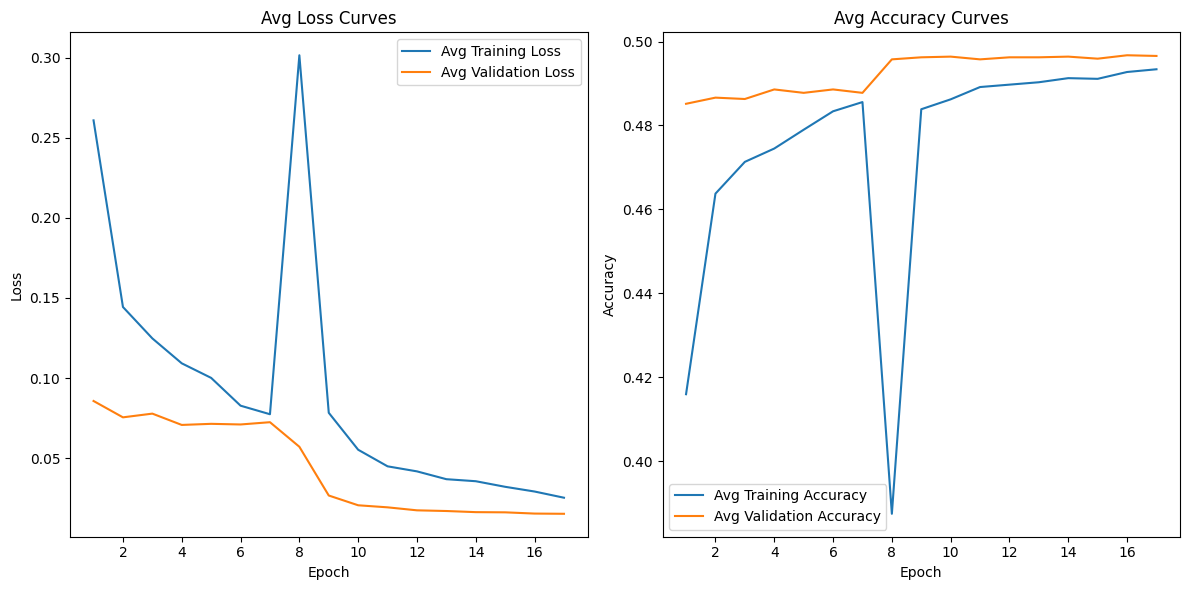

In [ ]:
# Combine history from all folds
avg_train_loss_b = np.mean(all_train_loss, axis=0)
avg_val_loss_b = np.mean(all_val_loss, axis=0)
avg_train_accuracy_b = np.mean(all_train_accuracy, axis=0)
avg_val_accuracy_b = np.mean(all_val_accuracy, axis=0)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(avg_train_loss_b) + 1), avg_train_loss_b, label='Avg Training Loss')
plt.plot(range(1, len(avg_val_loss_b) + 1), avg_val_loss_b, label='Avg Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Avg Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(avg_train_accuracy_b) + 1), avg_train_accuracy_b, label='Avg Training Accuracy')
plt.plot(range(1, len(avg_val_accuracy_b) + 1), avg_val_accuracy_b, label='Avg Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Avg Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [117]:
average_val_accuracy = np.mean(all_val_accuracy)

# Print the average validation accuracy
print(f"Average Validation Accuracy: {average_val_accuracy}")

Average Validation Accuracy: [0.48517433 0.4866406  0.48631477 0.48859563 0.48778105 0.48859563
 0.48778105 0.49576411 0.49625286 0.49641576 0.49576411 0.49625286
 0.49625286 0.49641576 0.49592701 0.49674162 0.49657869]


In [120]:
flat_val_accuracy = [item for sublist in all_val_accuracy for item in sublist]
flat_train_accuracy = [item for sublist in all_train_accuracy for item in sublist]

average_val_accuracy = np.mean(flat_val_accuracy)
average_train_accuracy = np.mean(flat_train_accuracy)

print(f"Average Validation Accuracy: {average_val_accuracy}")
print(f"Average Training Accuracy: {average_train_accuracy}")

Average Validation Accuracy: 0.9850880854270038
Average Training Accuracy: 0.9492732111145469


In [119]:
flat_train_loss = [item for sublist in all_train_loss for item in sublist]
flat_val_loss = [item for sublist in all_val_loss for item in sublist]

average_train_loss = np.mean(flat_train_loss)
average_val_loss = np.mean(flat_val_loss)

print(f"Average Training Loss: {average_train_loss}")
print(f"Average Validation Loss: {average_val_loss}")

Average Training Loss: 0.18584885141428778
Average Validation Loss: 0.0876987823011244


In [ ]:
# Get the best hyperparameters
best_params = study.best_params

best_params = study.best_params
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']
best_l2_reg = best_params['l2_reg']

In [ ]:
print("Best Hyperparameters:")
print(f"Learning Rate: {best_learning_rate}")
print(f"Batch Size: {best_batch_size}")
print(f"Dropout Rate: {best_dropout_rate}")
print(f"L2 Regularization: {best_l2_reg}")

Best Hyperparameters:
Learning Rate: 4.0244594068583686e-07
Batch Size: 8
Dropout Rate: 0.3181170309223371
L2 Regularization: 0.00016653762587868945


In [ ]:
# Define train_input_ids and train_attention_masks in the global scope
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
y_train_onehot = one_hot.transform(np.array(y_train).reshape(-1, 1)).toarray()

In [ ]:
# Final training with best hyperparameters and evaluation on the test set
final_model = model_builder(best_learning_rate, best_batch_size, best_dropout_rate, best_l2_reg, final_epochs, bert_model, MAX_LEN)
final_model.fit([train_input_ids, train_attention_masks], y_train_onehot, epochs=final_epochs, batch_size=best_batch_size, verbose=1)

Epoch 1/10
1151/1151 [==============================] - 442s 376ms/step - loss: 0.4290 - categorical_accuracy: 0.8593
Epoch 2/10
1151/1151 [==============================] - 432s 376ms/step - loss: 0.0966 - categorical_accuracy: 0.9839
Epoch 3/10
1151/1151 [==============================] - 432s 375ms/step - loss: 0.0676 - categorical_accuracy: 0.9850
Epoch 4/10
1151/1151 [==============================] - 432s 375ms/step - loss: 0.0548 - categorical_accuracy: 0.9873
Epoch 5/10
1151/1151 [==============================] - 432s 375ms/step - loss: 0.0493 - categorical_accuracy: 0.9882
Epoch 6/10
1151/1151 [==============================] - 432s 375ms/step - loss: 0.0414 - categorical_accuracy: 0.9896
Epoch 7/10
1151/1151 [==============================] - 432s 375ms/step - loss: 0.0429 - categorical_accuracy: 0.9879
Epoch 8/10
1151/1151 [==============================] - 432s 375ms/step - loss: 0.0396 - categorical_accuracy: 0.9885
Epoch 9/10
1151/1151 [==============================] - 

In [ ]:
test_predictions = final_model.predict([test_input_ids, test_attention_masks])
test_micro_f1 = f1_score(y_test_onehot.argmax(axis=1), test_predictions.argmax(axis=1), average='micro')
test_micro_recall = recall_score(y_test_onehot.argmax(axis=1), test_predictions.argmax(axis=1), average='micro')
test_micro_precision = precision_score(y_test_onehot.argmax(axis=1), test_predictions.argmax(axis=1), average='micro')

print("Test Micro F1:", test_micro_f1)
print("Test Micro Recall:", test_micro_recall)
print("Test Micro Precision:", test_micro_precision)

72/72 [==============================] - 38s 493ms/step
Test Micro F1: 0.9174989144594009
Test Micro Recall: 0.9174989144594008
Test Micro Precision: 0.9174989144594008


In [ ]:
# Evaluate the final model on test set
test_pred = final_model.predict([test_input_ids, test_attention_masks])
test_pred_labels = np.argmax(test_pred, axis=1)

72/72 [==============================] - 36s 494ms/step


In [ ]:
test_pred

array([[9.9939203e-01, 2.7240848e-04, 3.3554799e-04],
       [6.5282645e-04, 5.0269929e-04, 9.9884450e-01],
       [1.1284687e-03, 7.0462975e-04, 9.9816692e-01],
       ...,
       [5.0022104e-04, 3.5049746e-04, 9.9914932e-01],
       [2.9389155e-03, 1.2843651e-01, 8.6862457e-01],
       [4.8512153e-04, 9.9900538e-01, 5.0944532e-04]], dtype=float32)

In [ ]:
# converts the probabilities to 0s and 1s
y_pred =  np.zeros_like(test_pred)
y_pred

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [ ]:
# converts the probabilities to 0s and 1s: cont'd
y_pred[np.arange(len(y_pred)), test_pred.argmax(1)] = 1
y_pred

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
# Print the classification report
print("Classification Report for Test Set:")
print(classification_report(y_test_onehot.argmax(axis=1), test_pred_labels))

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       736
           1       0.92      0.91      0.91       797
           2       0.94      0.90      0.92       770

    accuracy                           0.92      2303
   macro avg       0.92      0.92      0.92      2303
weighted avg       0.92      0.92      0.92      2303



In [ ]:
# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test_onehot.argmax(axis=1), test_pred_labels)

In [ ]:
class_labels = ["Negative", "Neutral", "Positive"]

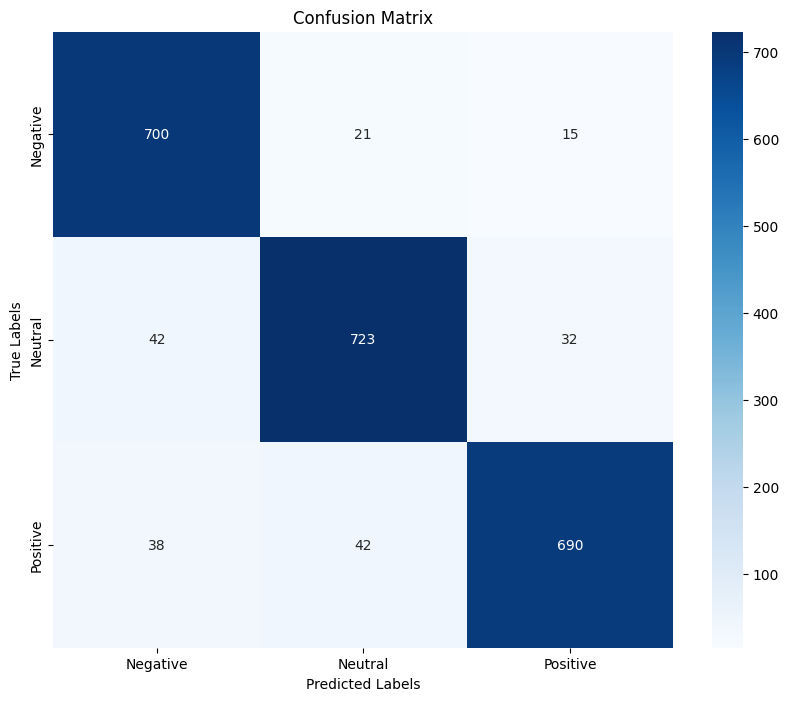

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate([test_input_ids, test_attention_masks], y_test_onehot, batch_size=best_batch_size)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
test_pred = final_model.predict([test_input_ids, test_attention_masks])
test_pred_labels = np.argmax(test_pred, axis=1)

# Calculate micro-averaged metrics for the test set
test_micro_f1 = f1_score(y_test_onehot.argmax(axis=1), test_pred_labels, average='micro')
test_micro_recall = recall_score(y_test_onehot.argmax(axis=1), test_pred_labels, average='micro')
test_micro_precision = precision_score(y_test_onehot.argmax(axis=1), test_pred_labels, average='micro')

print(f"Test Micro F1 Score: {test_micro_f1:.4f}, Test Micro Recall: {test_micro_recall:.4f}, Test Micro Precision: {test_micro_precision:.4f}")

288/288 [==============================] - 43s 140ms/step - loss: 0.3878 - categorical_accuracy: 0.9175
Test Loss: 0.3878, Test Accuracy: 0.9175
72/72 [==============================] - 35s 492ms/step
Test Micro F1 Score: 0.9175, Test Micro Recall: 0.9175, Test Micro Precision: 0.9175


In [ ]:
# Evaluate the final model on the train set
train_loss, train_accuracy = final_model.evaluate([train_input_ids, train_attention_masks],y_train_onehot, batch_size=best_batch_size)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
train_pred = final_model.predict([train_input_ids, train_attention_masks])
train_pred_labels = np.argmax(train_pred, axis=1)

# Calculate micro-averaged metrics for the train set
train_micro_f1 = f1_score(y_train_onehot.argmax(axis=1), train_pred_labels, average='micro')
train_micro_recall = recall_score(y_train_onehot.argmax(axis=1), train_pred_labels, average='micro')
train_micro_precision = precision_score(y_train_onehot.argmax(axis=1), train_pred_labels, average='micro')

print(f"Train Micro F1 Score: {train_micro_f1:.4f}, Train Micro Recall: {train_micro_recall:.4f}, Train Micro Precision: {train_micro_precision:.4f}")

1151/1151 [==============================] - 160s 139ms/step - loss: 0.0151 - categorical_accuracy: 0.9965
Train Loss: 0.0151, Train Accuracy: 0.9965
288/288 [==============================] - 142s 494ms/step
Train Micro F1 Score: 0.9965, Train Micro Recall: 0.9965, Train Micro Precision: 0.9965


In [ ]:
from sklearn.metrics import roc_auc_score

class_auc_scores = []

for class_index in range(3): 
    auc_score = roc_auc_score(y_test_onehot[:, class_index], test_pred[:, class_index])
    class_auc_scores.append(auc_score)

In [ ]:
class_auc_scores

[0.9831537346355541, 0.9815680815008473, 0.9739878516786542]

In [ ]:
from sklearn.metrics import roc_curve, auc

num_classes = 3

# Initialize dictionaries to store fpr, tpr, thresholds, and roc_auc for each class
class_fpr = {}
class_tpr = {}
class_thresholds = {}
class_roc_auc = {}

# Compute ROC curve and AUC for each class
for class_index in range(num_classes):  # Replace num_classes with the actual number of classes
    fpr, tpr, thresholds = roc_curve(y_test_onehot[:, class_index], test_pred[:, class_index])
    class_fpr[class_index] = fpr
    class_tpr[class_index] = tpr
    class_thresholds[class_index] = thresholds
    class_roc_auc[class_index] = auc(fpr, tpr)

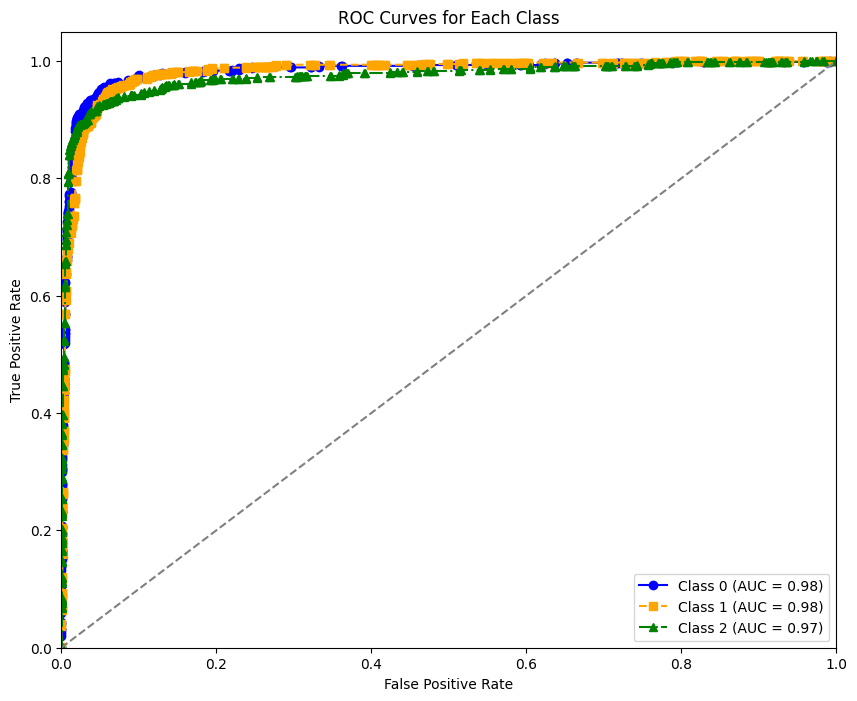

In [ ]:
import matplotlib.pyplot as plt

line_styles = ['-', '--', '-.', ':']
line_colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 's', '^', 'x']

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for class_index in range(num_classes):
    plt.plot(class_fpr[class_index], class_tpr[class_index],
             label=f'Class {class_index} (AUC = {class_roc_auc[class_index]:.2f})',
             linestyle=line_styles[class_index % len(line_styles)],
             color=line_colors[class_index % len(line_colors)],
             marker=markers[class_index % len(markers)])

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()

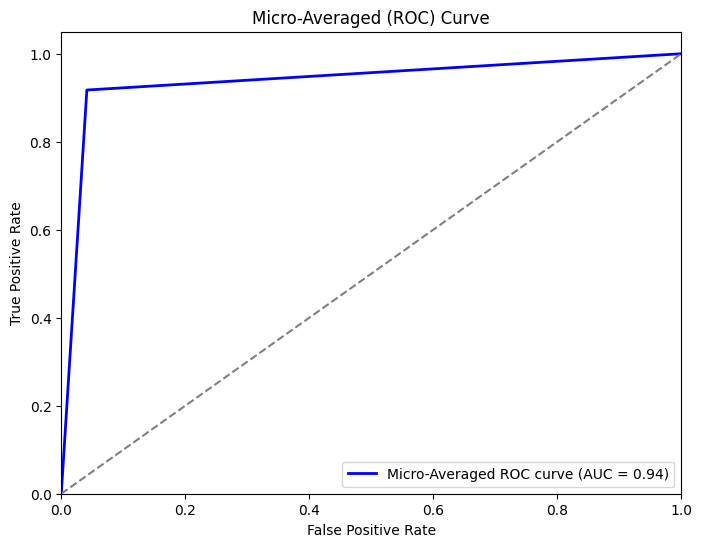

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Convert y_test to one-hot encoded format
y_test_onehot = label_binarize(y_test, classes=[0, 1, 2])

# Binarize the labels
y_test_bin = label_binarize(y_test_onehot.argmax(axis=1), classes=[0, 1, 2])
y_predicted_bin = label_binarize(y_pred.argmax(axis=1), classes=[0, 1, 2])

# Calculate micro-averaged ROC curve
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_predicted_bin.ravel())
roc_auc = auc(fpr, tpr)

# Plot micro-averaged ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Micro-Averaged ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

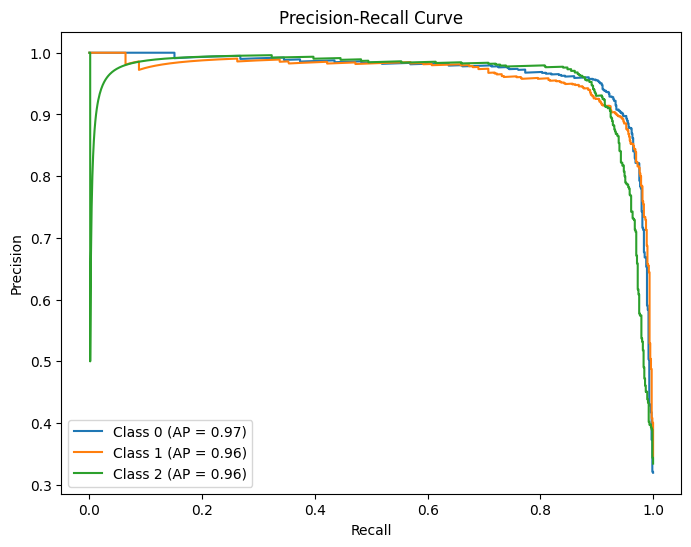

In [ ]:
# Initialize dictionaries to store precision, recall, and average precision for each class
class_precision = {}
class_recall = {}
class_avg_precision = {}

# Calculate precision, recall, and average precision for each class
for class_index in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, class_index], test_pred[:, class_index])
    avg_precision = average_precision_score(y_test_bin[:, class_index], test_pred[:, class_index])
    class_precision[class_index] = precision
    class_recall[class_index] = recall
    class_avg_precision[class_index] = avg_precision

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
for class_index in range(num_classes):
    plt.plot(class_recall[class_index], class_precision[class_index], label=f'Class {class_index} (AP = {class_avg_precision[class_index]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

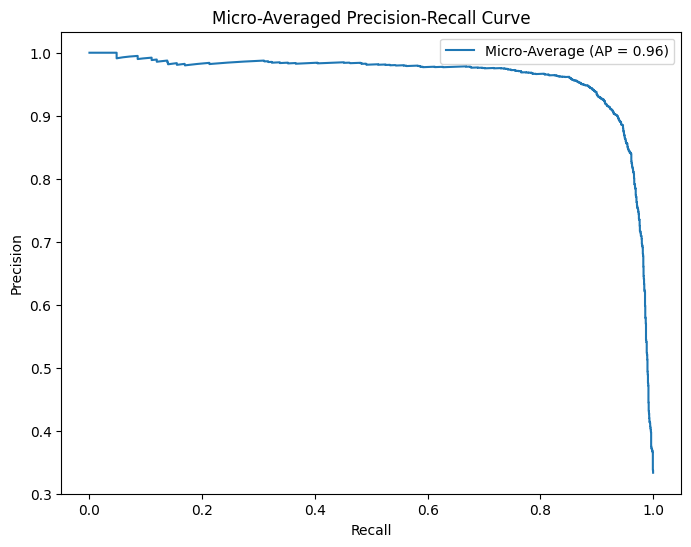

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate micro-averaged precision, recall, and average precision
micro_precision, micro_recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred.ravel())
micro_avg_precision = average_precision_score(y_test_bin, test_pred, average='micro')

# Plot micro-averaged precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(micro_recall, micro_precision, label=f'Micro-Average (AP = {micro_avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
def calc_pos_neg_rates(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    print("Precision => ", PPV)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    print("True Positive Rate (TPR) => ", TPR)

    # False positive rate or False alarm rate
    FPR = FP / (FP + TN)
    print("False positive rate (FPR) => ", FPR)

    # False negative rate or Miss Rate
    FNR = FN / (FN + TP)
    print("False Negative Rate (FNR) => ", FNR)

    #Total averages :
    print("")
    print("Average Precision => ", PPV.sum()/3)
    print("Average TPR => ", TPR.sum()/3)
    print("Average FPR => ", FPR.sum()/3)
    print("Average FNR => ", FNR.sum()/3)

In [ ]:
calc_pos_neg_rates(confusion_mat)

Precision =>  [0.8974359  0.91984733 0.93622795]
True Positive Rate (TPR) =>  [0.95108696 0.90715182 0.8961039 ]
False positive rate (FPR) =>  [0.05105297 0.04183267 0.03065884]
False Negative Rate (FNR) =>  [0.04891304 0.09284818 0.1038961 ]

Average Precision =>  0.917837058944499
Average TPR =>  0.9181142239826982
Average FPR =>  0.04118149188481979
Average FNR =>  0.08188577601730185


In [ ]:
def pie_plot(sectors):
    labels = 'Negative', 'Neutral', 'Positive'
    fig1, ax1 = plt.subplots()
    ax1.pie(sectors, wedgeprops=dict(width=0.6), labels=labels, autopct='%1.1f%%',
            colors=['tomato','royalblue','limegreen'])

    ax1.axis('equal')
    plt.show()

In [1]:
#y_pred_raveled = test_pred.ravel()[30:33]
#pie_plot(y_pred_raveled)

In [ ]:
lametizer = WordNetLemmatizer()

def predict_chat_text(chat_text:str):
    global lametizer
    # clean the text
    chat_text = clean_text(chat_text)
    # convert emoji
    chat_text = convert_emoji(chat_text)
    # break sentence into tokens
    chat_text = word_tokenize(chat_text)
    # lametize
    chat_text = [lametizer.lemmatize(token) for token in chat_text]
    # join list into sentence
    chat_text = " ".join(chat_text)
    # convert into number tokens
    txt_, txt_mask = tokenize([chat_text], MAX_LEN)
    text_clf = final_model.predict([txt_, txt_mask])
    y_pred_raveled = text_clf.ravel()[:3]
    pie_plot(y_pred_raveled)

1/1 [==============================] - 0s 66ms/step


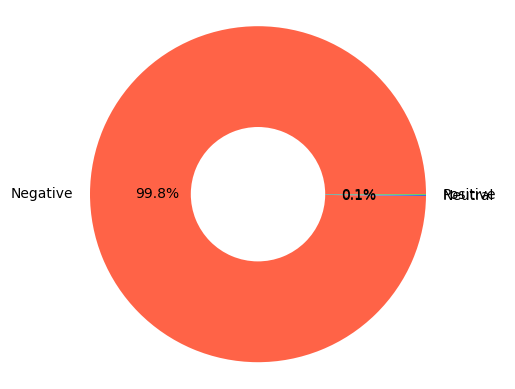

In [ ]:
predict_chat_text("@kems the stupid feminist is in the house, she is so low life 😠😠😠")

In [ ]:
# # save tokenizer
# tokenizer.save_pretrained('tokenizer_1')

# # Save the trained model weights
# final_model.save_weights('saved_model_weights.h5')

## LSTM

In [ ]:
lstm_tokenizer = Tokenizer()
lstm_tokenizer.fit_on_texts(data_final['clean_text'])
sequences = lstm_tokenizer.texts_to_sequences(data_final['clean_text'])

In [ ]:
# padding
max_sequence_length = max(len(seq) for seq in sequences)
sequences_padded = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
# initialize one-hot-encoding
one_hot = OneHotEncoder()

labels = one_hot.fit_transform(data_final['Sentiment'].values.reshape(-1,1)).toarray()

In [ ]:
len(sequences_padded), len(labels)

(11511, 11511)

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, labels, test_size=0.2, random_state=140, stratify=labels)

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 10
batch_size = 32

def build_lstm_model(trial):
    embedding_dim = 100
    num_class = len(data_final['Sentiment'].unique())
    max_sequence_length = sequences_padded.shape[1]

    # Suggest hyperparameters for the model
    learning_rate = trial.suggest_loguniform('learning_rate',  1e-7, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    dropout_rate = trial.suggest_uniform('dropout_rate',0.8, 0.95)
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)

    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=len(lstm_tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))

    lstm_units = 64

    # Add LSTM layer with recurrent dropout and L2 regularization
    lstm_model.add(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                        kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))

    lstm_model.add(Dropout(dropout_rate))

    # Add LSTM layer with recurrent dropout and L2 regularization
    lstm_model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2,
                        kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))

    lstm_model.add(Dense(num_class, activation="softmax", kernel_regularizer=l2(l2_reg)))  # Add L2 regularization

    lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    #lstm_model.summary()

    return lstm_model, early_stopping

In [ ]:
# Initialize lists to store history for all folds
al_train_loss = []
al_val_loss = []
al_train_accuracy = []
al_val_accuracy = []

def multilabel_stratified_k_fold(X, y, n_splits):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    splits = []
    y_argmax = np.argmax(y, axis=1) 
    for train_index, val_index in kf.split(X, y_argmax):
        splits.append((train_index, val_index))
    return splits


def objective(trial):
    scores = []
    history_list = []

    total_combined_objective = 0

    # custom multilabel stratified k-fold splitter
    cv_splits = multilabel_stratified_k_fold(X_train, y_train, n_splits=3)

    # Iterate through the custom k-fold splits
    for fold, (train_index, val_index) in enumerate(cv_splits, 1):
        print(f"Fold {fold}")

        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        lstm_model, early_stopping = build_lstm_model(trial)

        # Train with early stopping
        history = lstm_model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size,
                                 validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=2)

        history_list.append(history)

        al_train_loss.append(history.history['loss'])
        al_val_loss.append(history.history['val_loss'])
        al_train_accuracy.append(history.history['accuracy'])
        al_val_accuracy.append(history.history['val_accuracy'])

        # Evaluate the model's performance on the validation set
        val_pred = lstm_model.predict(X_val_fold)
        val_pred_labels = np.argmax(val_pred, axis=1)
        val_true_labels = np.argmax(y_val_fold, axis=1)

        # Calculate micro-averaged F1, recall, and precision scores
        micro_f1 = f1_score(val_true_labels, val_pred_labels, average='micro')
        micro_recall = recall_score(val_true_labels, val_pred_labels, average='micro')
        micro_precision = precision_score(val_true_labels, val_pred_labels, average='micro')

        # Combine the micro-averaged metrics into a single objective value
        combined_objective = (micro_f1 + micro_recall + micro_precision) / 3.0

        scores.append(combined_objective)

    return np.mean(scores)

[I 2023-09-02 17:30:43,482] A new study created in memory with name: no-name-588a15fa-965e-4790-839e-0068e6058653


Fold 1
Epoch 1/10
192/192 - 29s - loss: 1.2782 - accuracy: 0.3671 - val_loss: 1.2779 - val_accuracy: 0.3707 - 29s/epoch - 153ms/step
Epoch 2/10
192/192 - 23s - loss: 1.2781 - accuracy: 0.3669 - val_loss: 1.2778 - val_accuracy: 0.3710 - 23s/epoch - 120ms/step
Epoch 3/10
192/192 - 23s - loss: 1.2781 - accuracy: 0.3658 - val_loss: 1.2777 - val_accuracy: 0.3713 - 23s/epoch - 121ms/step
Epoch 4/10
192/192 - 24s - loss: 1.2778 - accuracy: 0.3581 - val_loss: 1.2775 - val_accuracy: 0.3710 - 24s/epoch - 124ms/step
Epoch 5/10
192/192 - 23s - loss: 1.2777 - accuracy: 0.3674 - val_loss: 1.2774 - val_accuracy: 0.3713 - 23s/epoch - 121ms/step
Epoch 6/10
192/192 - 23s - loss: 1.2781 - accuracy: 0.3617 - val_loss: 1.2773 - val_accuracy: 0.3710 - 23s/epoch - 120ms/step
Epoch 7/10
192/192 - 23s - loss: 1.2771 - accuracy: 0.3711 - val_loss: 1.2771 - val_accuracy: 0.3707 - 23s/epoch - 121ms/step
Epoch 8/10
192/192 - 23s - loss: 1.2772 - accuracy: 0.3799 - val_loss: 1.2770 - val_accuracy: 0.3700 - 23s/epoc

[I 2023-09-02 17:43:40,131] Trial 0 finished with value: 0.34448031857929934 and parameters: {'learning_rate': 2.095107579812001e-07, 'batch_size': 16, 'dropout_rate': 0.9274526004229476, 'l2_reg': 0.00035732355198611713}. Best is trial 0 with value: 0.34448031857929934.


Fold 1
Epoch 1/10
192/192 - 31s - loss: 1.0962 - accuracy: 0.3705 - val_loss: 1.0924 - val_accuracy: 0.3863 - 31s/epoch - 161ms/step
Epoch 2/10
192/192 - 23s - loss: 1.0896 - accuracy: 0.3877 - val_loss: 1.0833 - val_accuracy: 0.4062 - 23s/epoch - 119ms/step
Epoch 3/10
192/192 - 23s - loss: 1.0802 - accuracy: 0.4133 - val_loss: 1.0710 - val_accuracy: 0.4166 - 23s/epoch - 119ms/step
Epoch 4/10
192/192 - 23s - loss: 1.0684 - accuracy: 0.4288 - val_loss: 1.0572 - val_accuracy: 0.4267 - 23s/epoch - 120ms/step
Epoch 5/10
192/192 - 23s - loss: 1.0580 - accuracy: 0.4352 - val_loss: 1.0447 - val_accuracy: 0.4270 - 23s/epoch - 120ms/step
Epoch 6/10
192/192 - 23s - loss: 1.0450 - accuracy: 0.4353 - val_loss: 1.0346 - val_accuracy: 0.4283 - 23s/epoch - 121ms/step
Epoch 7/10
192/192 - 23s - loss: 1.0358 - accuracy: 0.4544 - val_loss: 1.0265 - val_accuracy: 0.4404 - 23s/epoch - 119ms/step
Epoch 8/10
192/192 - 23s - loss: 1.0287 - accuracy: 0.4718 - val_loss: 1.0184 - val_accuracy: 0.4651 - 23s/epoc

[I 2023-09-02 17:56:09,354] Trial 1 finished with value: 0.4891385926796245 and parameters: {'learning_rate': 3.077390736775294e-05, 'batch_size': 8, 'dropout_rate': 0.9330084912443877, 'l2_reg': 1.3112238693757384e-06}. Best is trial 1 with value: 0.4891385926796245.


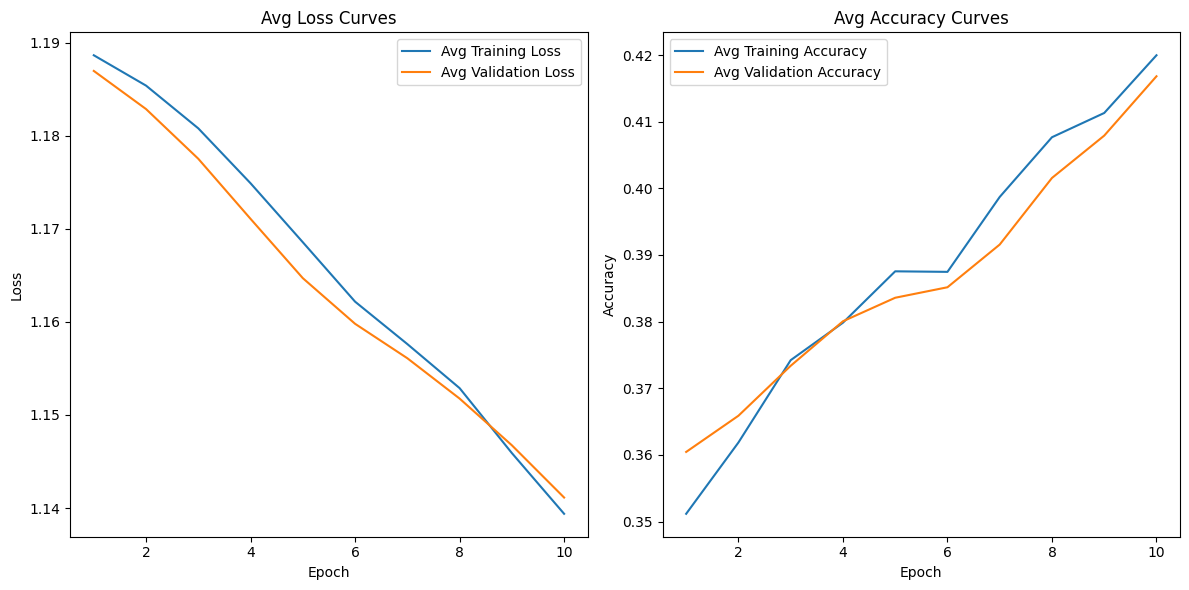

In [ ]:
# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

# Combine history from all folds
avg_train_loss = np.mean(al_train_loss, axis=0)
avg_val_loss = np.mean(al_val_loss, axis=0)
avg_train_accuracy = np.mean(al_train_accuracy, axis=0)
avg_val_accuracy = np.mean(al_val_accuracy, axis=0)

# Plot aggregated loss and accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(avg_train_loss) + 1), avg_train_loss, label='Avg Training Loss')
plt.plot(range(1, len(avg_val_loss) + 1), avg_val_loss, label='Avg Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Avg Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(avg_train_accuracy) + 1), avg_train_accuracy, label='Avg Training Accuracy')
plt.plot(range(1, len(avg_val_accuracy) + 1), avg_val_accuracy, label='Avg Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Avg Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

# Get the best hyperparameters
best_params = study.best_params

In [ ]:
# After running the optimization study
best_trial = study.best_trial

best_params = best_trial.params
best_score = best_trial.value

print("Best Parameters:", best_params)
print("Best Objective Value (Score):", best_score)

Best Parameters: {'learning_rate': 3.077390736775294e-05, 'batch_size': 8, 'dropout_rate': 0.9330084912443877, 'l2_reg': 1.3112238693757384e-06}
Best Objective Value (Score): 0.4891385926796245


In [ ]:
# Create the best LSTM model using the best hyperparameters
best_lstm_model, _ = build_lstm_model(study.best_trial)

# Define the batch_size for training the best model
batch_size = best_params['batch_size']

# Train the best model on the entire training dataset
best_lstm_model.fit(sequences_padded, labels, epochs=epochs, batch_size=batch_size)

Epoch 1/10
1439/1439 [==============================] - 152s 102ms/step - loss: 1.0856 - accuracy: 0.3896
Epoch 2/10
1439/1439 [==============================] - 147s 102ms/step - loss: 1.0473 - accuracy: 0.4528
Epoch 3/10
1439/1439 [==============================] - 147s 102ms/step - loss: 1.0202 - accuracy: 0.4710
Epoch 4/10
1439/1439 [==============================] - 147s 102ms/step - loss: 0.9681 - accuracy: 0.5099
Epoch 5/10
1439/1439 [==============================] - 147s 102ms/step - loss: 0.8804 - accuracy: 0.5707
Epoch 6/10
1439/1439 [==============================] - 147s 102ms/step - loss: 0.7903 - accuracy: 0.6258
Epoch 7/10
1439/1439 [==============================] - 148s 103ms/step - loss: 0.7122 - accuracy: 0.6734
Epoch 8/10
1439/1439 [==============================] - 147s 102ms/step - loss: 0.6385 - accuracy: 0.7235
Epoch 9/10
1439/1439 [==============================] - 147s 102ms/step - loss: 0.5727 - accuracy: 0.7672
Epoch 10/10
1439/1439 [=======================

In [ ]:
# Make predictions on the test set
y_pred = best_lstm_model.predict(X_test)

72/72 [==============================] - 2s 21ms/step


In [ ]:
#  evaluate the model on the test set
test_loss, test_accuracy = best_lstm_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

72/72 [==============================] - 2s 23ms/step - loss: 0.4244 - accuracy: 0.8398
Test Loss: 0.42441171407699585
Test Accuracy: 0.8397741913795471


In [ ]:
# Make predictions on the test set
y_pred = best_lstm_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

72/72 [==============================] - 2s 22ms/step


In [ ]:
# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [ ]:
# Make predictions on the training set
y_train_pred = best_lstm_model.predict(X_train)
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

288/288 [==============================] - 6s 20ms/step


In [ ]:
train_loss, train_accuracy = best_lstm_model.evaluate(X_train, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

288/288 [==============================] - 6s 21ms/step - loss: 0.4117 - accuracy: 0.8487
Train Loss: 0.41172802448272705
Train Accuracy: 0.848718523979187


In [ ]:
# Calculate classification report for train set
train_classification_rep = classification_report(
    np.argmax(y_train, axis=1), y_train_pred_labels, output_dict=True
)

# Calculate classification report for test set
test_classification_rep = classification_report(
    np.argmax(y_test, axis=1), y_pred_labels, output_dict=True
)

# Calculate micro-averaged precision, recall, and F1-score for train set
train_micro_precision, train_micro_recall, train_micro_f1, _ = precision_recall_fscore_support(
    np.argmax(y_train, axis=1), y_train_pred_labels, average='micro'
)

# Calculate micro-averaged precision, recall, and F1-score for test set
test_micro_precision, test_micro_recall, test_micro_f1, _ = precision_recall_fscore_support(
    np.argmax(y_test, axis=1), y_pred_labels, average='micro'
)

# Print micro-averaged classification report for train set
print("Micro-Averaged Classification Report (Train Set):")
print(train_classification_rep)
print("Micro-Averaged Precision (Train Set):", train_micro_precision)
print("Micro-Averaged Recall (Train Set):", train_micro_recall)
print("Micro-Averaged F1-Score (Train Set):", train_micro_f1)

# Print micro-averaged classification report for test set
print("\nMicro-Averaged Classification Report (Test Set):")
print(test_classification_rep)
print("Micro-Averaged Precision (Test Set):", test_micro_precision)
print("Micro-Averaged Recall (Test Set):", test_micro_recall)
print("Micro-Averaged F1-Score (Test Set):", test_micro_f1)

Micro-Averaged Classification Report (Train Set):
{'0': {'precision': 0.8022875816993464, 'recall': 0.7999348321928967, 'f1-score': 0.8011094795235765, 'support': 3069}, '1': {'precision': 0.8695273992461583, 'recall': 0.9768729641693811, 'f1-score': 0.9200797668354042, 'support': 3070}, '2': {'precision': 0.8747684327528714, 'recall': 0.7693059628543499, 'f1-score': 0.8186546463245491, 'support': 3069}, 'accuracy': 0.8487185056472633, 'macro avg': {'precision': 0.8488611378994587, 'recall': 0.8487045864055425, 'f1-score': 0.8466146308945098, 'support': 9208}, 'weighted avg': {'precision': 0.8488633822805781, 'recall': 0.8487185056472633, 'f1-score': 0.8466226092976312, 'support': 9208}}
Micro-Averaged Precision (Train Set): 0.8487185056472633
Micro-Averaged Recall (Train Set): 0.8487185056472633
Micro-Averaged F1-Score (Train Set): 0.8487185056472633

Micro-Averaged Classification Report (Test Set):
{'0': {'precision': 0.7953367875647669, 'recall': 0.7994791666666666, 'f1-score': 0.79

In [ ]:
print('Classification Report')
print()
print(classification_report(y_test_labels, y_pred_labels))

Classification Report

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       768
           1       0.85      0.98      0.91       767
           2       0.88      0.74      0.81       768

    accuracy                           0.84      2303
   macro avg       0.84      0.84      0.84      2303
weighted avg       0.84      0.84      0.84      2303



In [ ]:
class_labels = ["Negative", "Neutral", "Positive"]

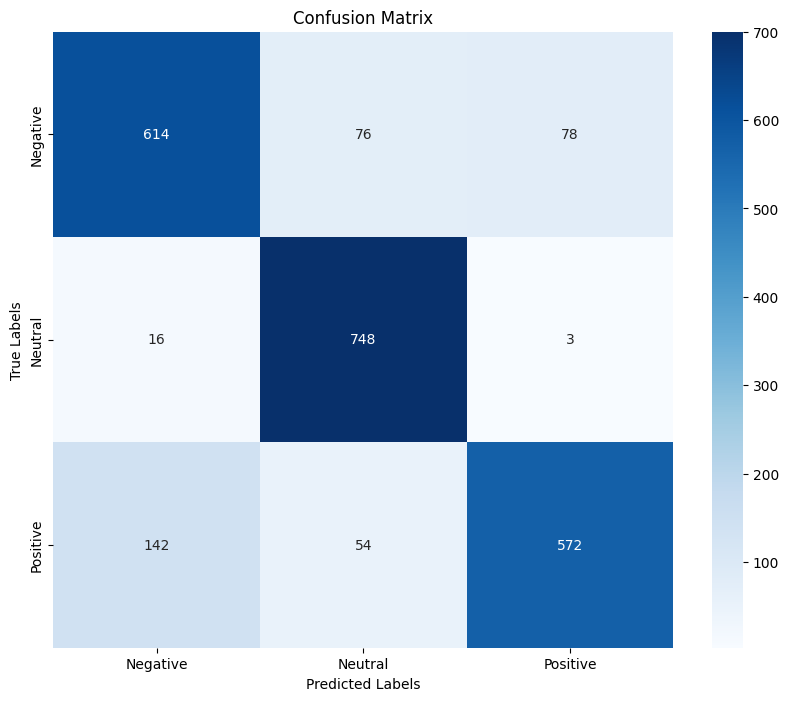

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']

# Plot a confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, vmax=700)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

72/72 [==============================] - 1s 20ms/step


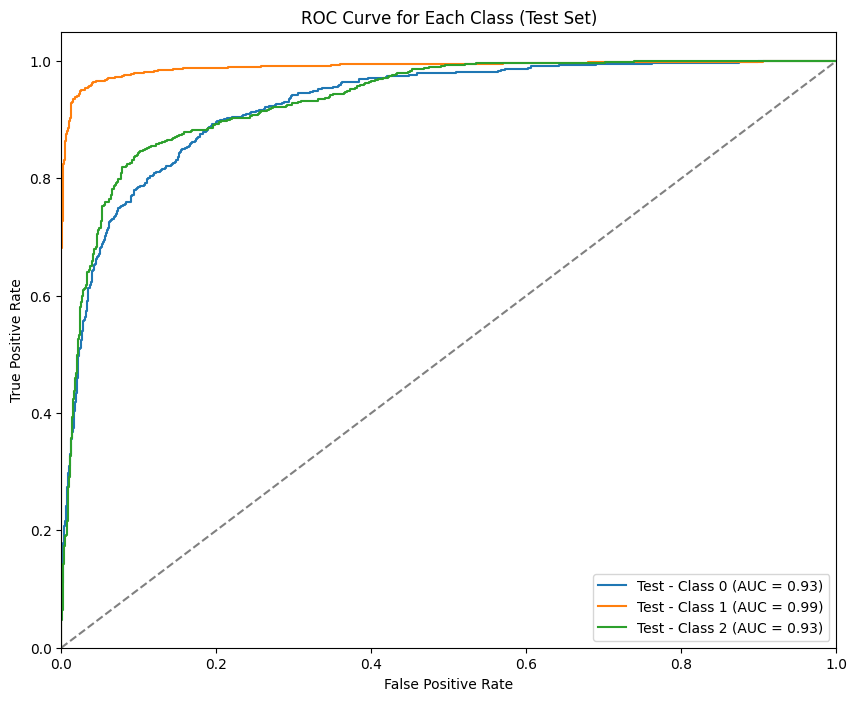

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate predicted probabilities for the test set
y_test_pred_probs = best_lstm_model.predict(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(data_final['Sentiment'].unique())):
    fpr_test, tpr_test, _ = roc_curve(y_test[:, i], y_test_pred_probs[:, i])
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, label=f"Test - Class {i} (AUC = {roc_auc_test:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Test Set)')
plt.legend(loc="lower right")
plt.show()

72/72 [==============================] - 1s 20ms/step


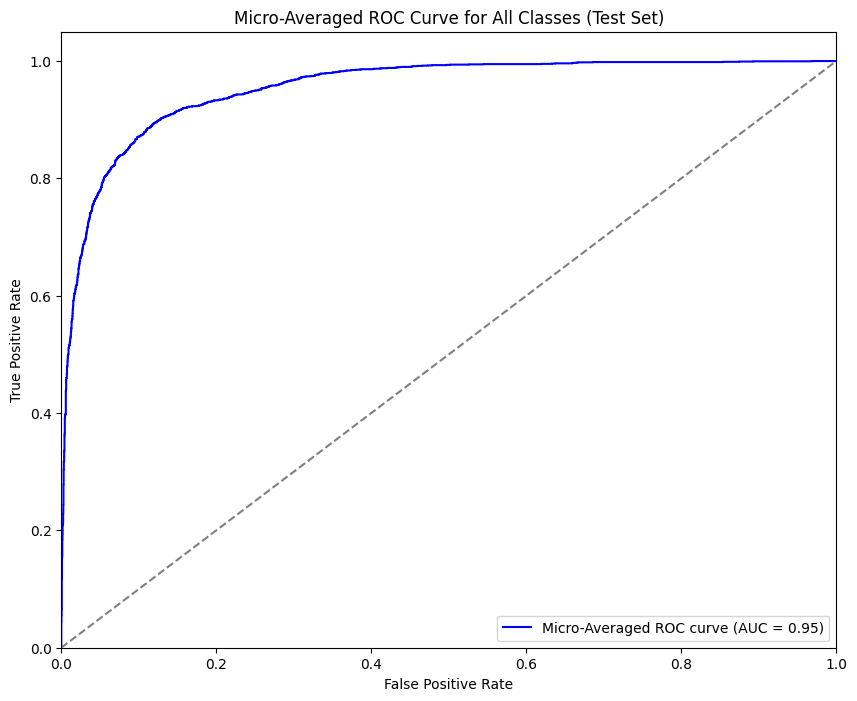

In [ ]:
# Calculate predicted probabilities for the test set
y_test_pred_probs = best_lstm_model.predict(X_test)

# Calculate micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_test_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the micro-averaged ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, color='blue', label=f'Micro-Averaged ROC curve (AUC = {roc_auc_micro:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve for All Classes (Test Set)')
plt.legend(loc="lower right")
plt.show()

72/72 [==============================] - 1s 20ms/step


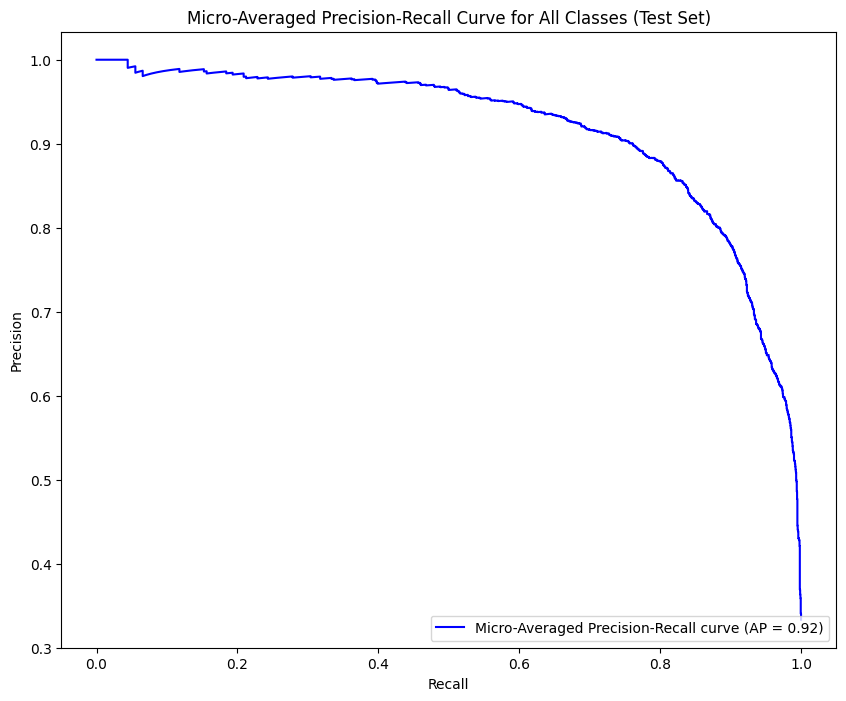

In [ ]:
# Calculate predicted probabilities for the test set
y_test_pred_probs = best_lstm_model.predict(X_test)

# Calculate micro-averaged precision-recall curve
precision_micro, recall_micro, _ = precision_recall_curve(y_test.ravel(), y_test_pred_probs.ravel())
average_precision_micro = average_precision_score(y_test, y_test_pred_probs, average='micro')

# Plot the micro-averaged precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall_micro, precision_micro, color='blue', label=f'Micro-Averaged Precision-Recall curve (AP = {average_precision_micro:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve for All Classes (Test Set)')
plt.legend(loc="lower right")
plt.show()

72/72 [==============================] - 1s 20ms/step


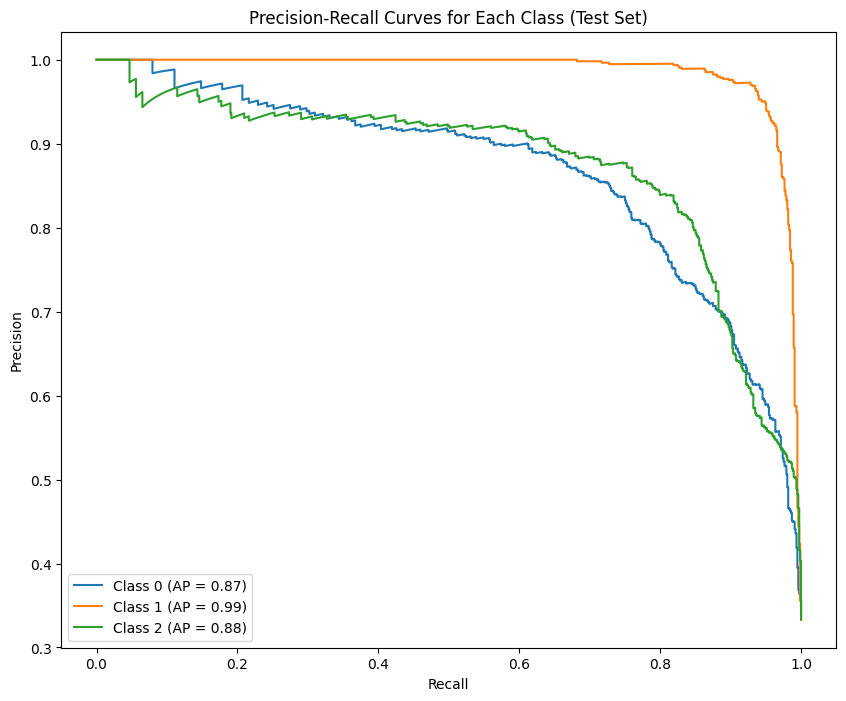

In [ ]:
# Calculate predicted probabilities for the test set
y_test_pred_probs = best_lstm_model.predict(X_test)

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(data_final['Sentiment'].unique())):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_test_pred_probs[:, i])
    average_precision = average_precision_score(y_test[:, i], y_test_pred_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class (Test Set)')
plt.legend(loc="lower left")
plt.show()

In [ ]:
def calc_pos_neg_rates_2(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    print("Precision => ", PPV)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    print("True Positive Rate (TPR) => ", TPR)

    # False positive rate or False alarm rate
    FPR = FP / (FP + TN)
    print("False positive rate (FPR) => ", FPR)

    # False negative rate or Miss Rate
    FNR = FN / (FN + TP)
    print("False Negative Rate (FNR) => ", FNR)

    #Total averages :
    print("")
    print("Average Precision => ", PPV.sum()/3)
    print("Average TPR => ", TPR.sum()/3)
    print("Average FPR => ", FPR.sum()/3)
    print("Average FNR => ", FNR.sum()/3)

In [ ]:
calc_pos_neg_rates_2(conf_matrix)

Precision =>  [0.79533679 0.85193622 0.87595712]
True Positive Rate (TPR) =>  [0.79947917 0.97522816 0.74479167]
False positive rate (FPR) =>  [0.1029316  0.08463542 0.05276873]
False Negative Rate (FNR) =>  [0.20052083 0.02477184 0.25520833]

Average Precision =>  0.841076709074558
Average TPR =>  0.8398329983340576
Average FPR =>  0.08011191413318856
Average FNR =>  0.16016700166594233


In [ ]:
# # save LSTM tokenizer
# with open('lstm_tokenizer.pkl', 'wb') as handle:
#     pickle.dump(lstm_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # save LSTM model
# #best_lstm_model.save('lstm_model.h5')

In [ ]:
# # Save LSTM model weights
# best_lstm_model.save_weights('lstm_model_weights.h5')

## Support Vector Classifier (SVC)

In [ ]:
X = data_final['clean_text']
y = data_final['Sentiment']

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=140, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=140, stratify=y_temp)

In [ ]:
y_test.shape

(1727,)

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
trial_train_accuracies = []
trial_val_accuracies = []

def objective(trial):
    max_feat = trial.suggest_int("max_feat", 1000, 10000)
    C = trial.suggest_float("C", 0.001, 0.1)

    vectorizer = TfidfVectorizer(max_features=max_feat)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_valid_tfidf = vectorizer.transform(X_valid)  # Use the validation set here

    svm_model = SVC(kernel='linear', C=C, random_state=42)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_f1_scores = []
    fold_recall_scores = []
    fold_precision_scores = []

    for train_index, val_index in skf.split(X_train_tfidf, y_train):  # Use the transformed X_train_tfidf
        X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        svm_model.fit(X_train_fold, y_train_fold)

        y_train_pred_fold = svm_model.predict(X_train_fold)
        y_val_pred_fold = svm_model.predict(X_val_fold)

        train_accuracy = accuracy_score(y_train_fold, y_train_pred_fold)
        val_accuracy = accuracy_score(y_val_fold, y_val_pred_fold)

        fold_train_accuracies.append(train_accuracy)
        fold_val_accuracies.append(val_accuracy)

        micro_f1_score = f1_score(y_val_fold, y_val_pred_fold, average='micro')
        micro_recall = recall_score(y_val_fold, y_val_pred_fold, average='micro')
        micro_precision = precision_score(y_val_fold, y_val_pred_fold, average='micro')

        fold_f1_scores.append(micro_f1_score)
        fold_recall_scores.append(micro_recall)
        fold_precision_scores.append(micro_precision)

    avg_train_accuracy = sum(fold_train_accuracies) / len(fold_train_accuracies)
    avg_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)

    # Store the trial-based accuracies
    trial_train_accuracies.append(avg_train_accuracy)
    trial_val_accuracies.append(avg_val_accuracy)

    avg_f1_score = sum(fold_f1_scores) / len(fold_f1_scores)
    avg_recall = sum(fold_recall_scores) / len(fold_recall_scores)
    avg_precision = sum(fold_precision_scores) / len(fold_precision_scores)

    # Combine the metrics into a single objective value (e.g., average or weighted average)
    combined_objective = (avg_f1_score + avg_recall + avg_precision) / 3.0

    return combined_objective

[I 2023-09-02 19:45:18,010] A new study created in memory with name: no-name-f9a9976e-2403-47a8-b343-10e25848b956
[I 2023-09-02 19:45:43,553] Trial 0 finished with value: 0.4619577430481893 and parameters: {'max_feat': 2155, 'C': 0.020790822836581468}. Best is trial 0 with value: 0.4619577430481893.
[I 2023-09-02 19:46:07,022] Trial 1 finished with value: 0.6658800049732548 and parameters: {'max_feat': 2116, 'C': 0.09081968933019469}. Best is trial 1 with value: 0.6658800049732548.
[I 2023-09-02 19:46:31,537] Trial 2 finished with value: 0.5917834064300118 and parameters: {'max_feat': 2300, 'C': 0.05808428471512455}. Best is trial 1 with value: 0.6658800049732548.
[I 2023-09-02 19:46:59,364] Trial 3 finished with value: 0.49869623072574853 and parameters: {'max_feat': 7595, 'C': 0.036576604255101376}. Best is trial 1 with value: 0.6658800049732548.
[I 2023-09-02 19:47:21,198] Trial 4 finished with value: 0.6761820377680808 and parameters: {'max_feat': 1056, 'C': 0.08332798252775905}. B

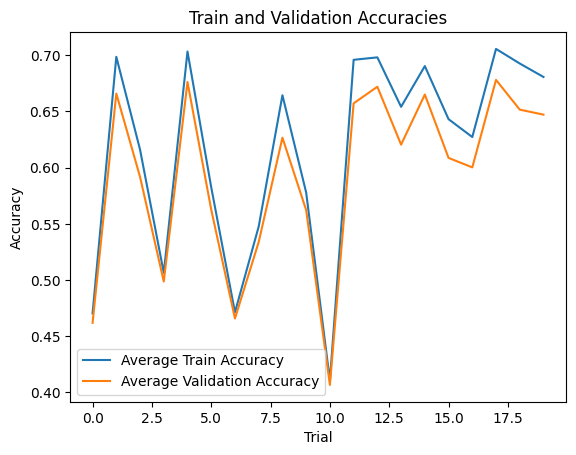

In [ ]:
# # Create an Optuna study and run the optimization process
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

In [ ]:
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'max_feat': 1034, 'C': 0.08438324270293998}


In [ ]:
best_max_feat = best_params["max_feat"]
best_C = best_params["C"]

final_vectorizer = TfidfVectorizer(max_features=best_max_feat)
X_train_tfidf = final_vectorizer.fit_transform(X_train)
X_test_tfidf = final_vectorizer.transform(X_test)

final_svm_model = SVC(kernel='linear', C=best_C, random_state=42)
final_svm_model.fit(X_train_tfidf, y_train)

y_pred_test = final_svm_model.predict(X_test_tfidf)
final_accuracy_test = accuracy_score(y_test, y_pred_test)
print("Final Test Accuracy:", final_accuracy_test)

Final Test Accuracy: 0.7168500289519398


In [ ]:
# Fit the final SVM model on the entire training set
final_svm_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_test = final_svm_model.predict(X_test_tfidf)

# Calculate final accuracy on the test set
final_accuracy_test = accuracy_score(y_test, y_pred_test)
print("Final Test Accuracy:", final_accuracy_test)

# Print the classification report
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:\n", class_report)

Final Test Accuracy: 0.7168500289519398
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.64      0.73       576
           1       0.59      0.94      0.72       576
           2       0.91      0.56      0.70       575

    accuracy                           0.72      1727
   macro avg       0.78      0.72      0.72      1727
weighted avg       0.78      0.72      0.72      1727



In [ ]:
# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[371 181  24]
 [ 24 543   9]
 [ 47 204 324]]


In [ ]:
class_labels = ["Negative", "Neutral", "Positive"]

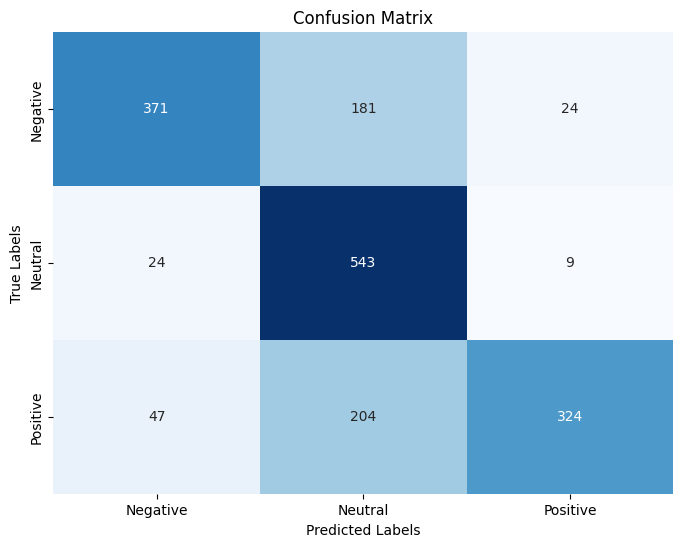

In [ ]:
# Plot the confusion matrix
confu_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Lists to store micro-averaged metrics
micro_precisions = []
micro_recalls = []
micro_f1_scores = []

# Calculate micro-averaged metrics
micro_precision = precision_score(y_test, y_pred_test, average='micro')
micro_recall = recall_score(y_test, y_pred_test, average='micro')
micro_f1 = f1_score(y_test, y_pred_test, average='micro')

# Print micro-averaged metrics
print("Micro-Averaged Precision:", micro_precision)
print("Micro-Averaged Recall:", micro_recall)
print("Micro-Averaged F1-score:", micro_f1)

# Append micro-averaged metrics to the lists
micro_precisions.append(micro_precision)
micro_recalls.append(micro_recall)
micro_f1_scores.append(micro_f1)

Micro-Averaged Precision: 0.7168500289519398
Micro-Averaged Recall: 0.7168500289519398
Micro-Averaged F1-score: 0.7168500289519399


In [ ]:
# Lists to store micro-averaged metrics
micro_precisions_train = []
micro_recalls_train = []
micro_f1_scores_train = []

# Calculate micro-averaged metrics for the train set
micro_precision_train = precision_score(y_train, final_svm_model.predict(X_train_tfidf), average='micro')
micro_recall_train = recall_score(y_train, final_svm_model.predict(X_train_tfidf), average='micro')
micro_f1_train = f1_score(y_train, final_svm_model.predict(X_train_tfidf), average='micro')

# Print micro-averaged metrics for the train set
print("Micro-Averaged Precision (Train):", micro_precision_train)
print("Micro-Averaged Recall (Train):", micro_recall_train)
print("Micro-Averaged F1-score (Train):", micro_f1_train)

# Append micro-averaged metrics for the train set to the lists
micro_precisions_train.append(micro_precision_train)
micro_recalls_train.append(micro_recall_train)
micro_f1_scores_train.append(micro_f1_train)

Micro-Averaged Precision (Train): 0.7420876256671217
Micro-Averaged Recall (Train): 0.7420876256671217
Micro-Averaged F1-score (Train): 0.7420876256671217


In [ ]:
from sklearn.metrics import roc_auc_score

num_classes =3
# Lists to store AUC scores for each class
class_auc_scores_train = []
class_auc_scores_test = []

# Calculate and print AUC scores for each class on the test set
for class_idx in range(num_classes):
    auc_score_test = roc_auc_score(y_test == class_idx, y_pred_test == class_idx)
    class_auc_scores_test.append(auc_score_test)
    print(f"Class {class_idx} AUC (Test):", auc_score_test)

Class 0 AUC (Test): 0.7912058656723622
Class 1 AUC (Test): 0.8041082935128874
Class 2 AUC (Test): 0.7674162137681159


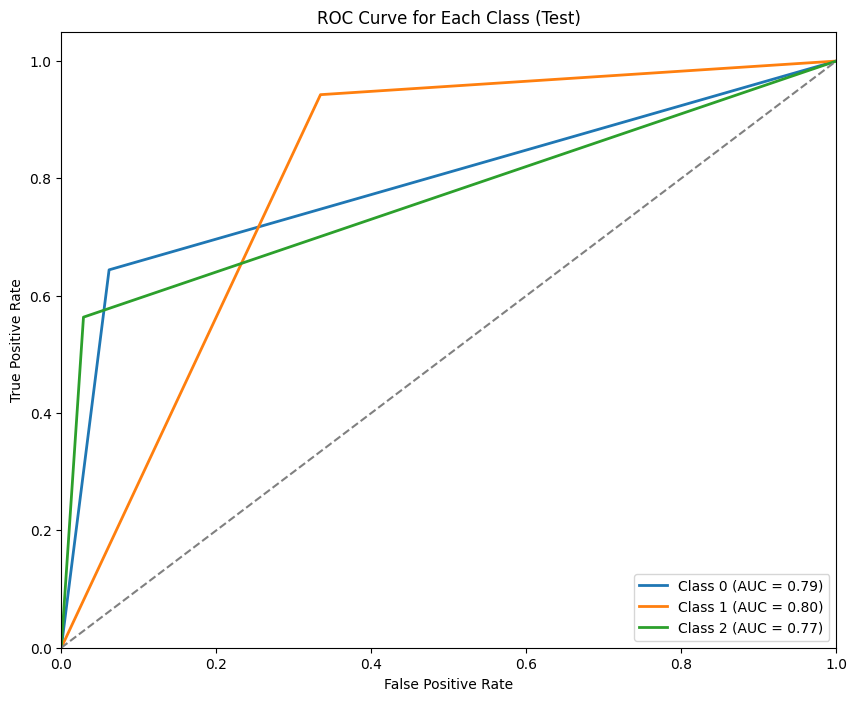

In [ ]:

# Calculate AUC scores and plot ROC curves for each class on the test set
plt.figure(figsize=(10, 8))
for class_idx in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test == class_idx, y_pred_test == class_idx)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='Class %d (AUC = %0.2f)' % (class_idx, roc_auc))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Test)')
plt.legend(loc="lower right")
plt.show()

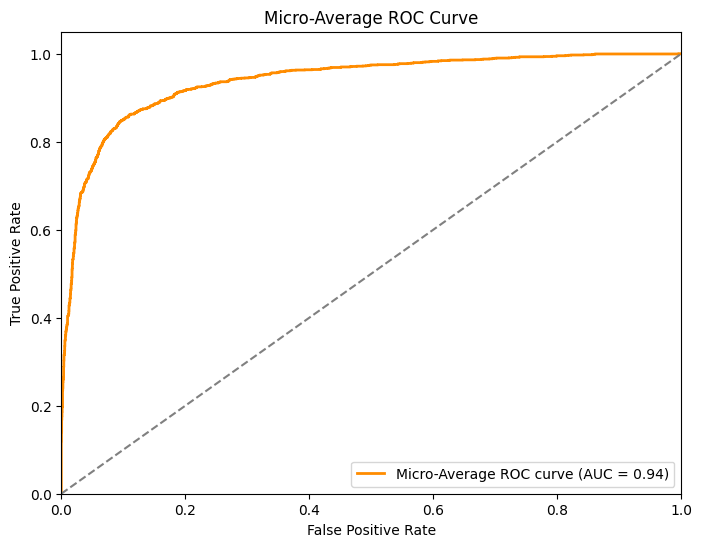

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

# Binarize the labels for micro-average ROC calculation
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

# Create and train the final LinearSVC model
final_linear_svm_model = LinearSVC(C=best_C, random_state=42)
final_linear_svm_model.fit(X_train_tfidf, y_train)

# Convert the problem to binary classification 
ovr_classifier = OneVsRestClassifier(final_linear_svm_model)
ovr_classifier.fit(X_train_tfidf, y_train)

# Get predicted decision scores for each class
y_pred_test_scores = ovr_classifier.decision_function(X_test_tfidf)

# Calculate micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_test_scores.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2, label='Micro-Average ROC curve (AUC = %0.2f)' % roc_auc_micro)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve')
plt.legend(loc="lower right")
plt.show()

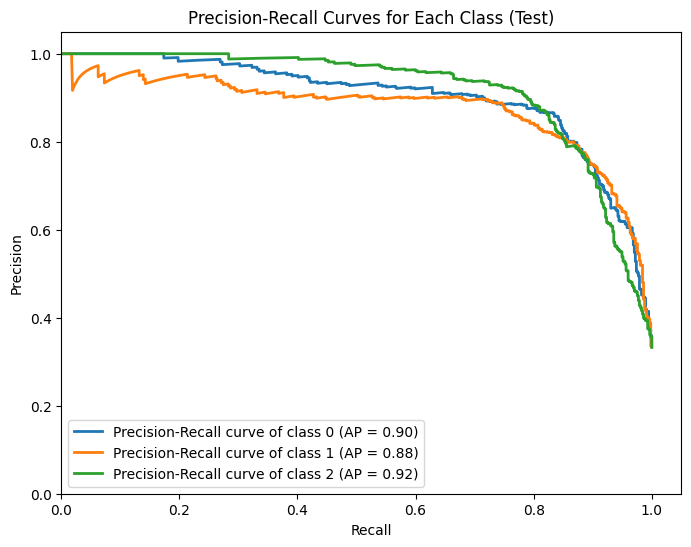

In [ ]:
num_classes = 3

# Calculate precision-recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes): 
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_test_scores[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot precision-recall curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Precision-Recall curve of class {0} (AP = {1:.2f})'.format(i, average_precision[i]))

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class (Test)')
plt.legend(loc="lower left")
plt.show()

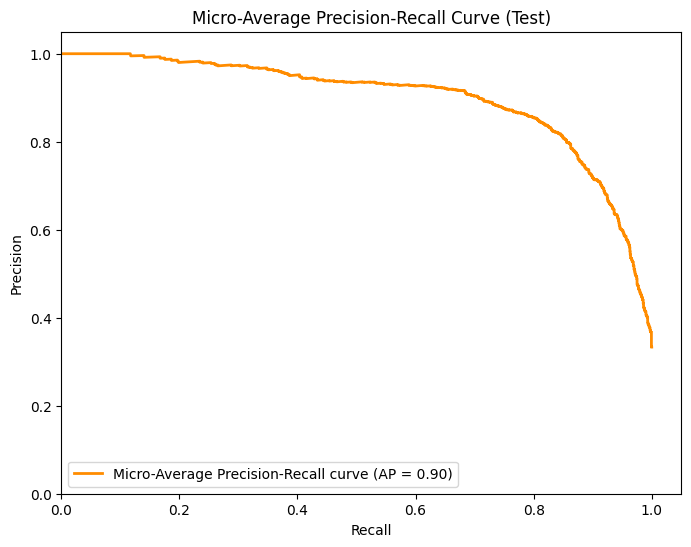

In [ ]:
# Calculate micro-average precision-recall curve and average precision
precision_micro, recall_micro, _ = precision_recall_curve(y_test_binarized.ravel(), y_pred_test_scores.ravel())
average_precision_micro = auc(recall_micro, precision_micro)

# Plot micro-average precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, color='darkorange', lw=2, label='Micro-Average Precision-Recall curve (AP = %0.2f)' % average_precision_micro)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Average Precision-Recall Curve (Test)')
plt.legend(loc="lower left")
plt.show()

In [ ]:
def calc_pos_neg_rates(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    print("Precision => ", PPV)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    print("True Positive Rate (TPR) => ", TPR)

    # False positive rate or False alarm rate
    FPR = FP / (FP + TN)
    print("False positive rate (FPR) => ", FPR)

    # False negative rate or Miss Rate
    FNR = FN / (FN + TP)
    print("False Negative Rate (FNR) => ", FNR)

    #Total averages :
    print("")
    print("Average Precision => ", PPV.sum()/3)
    print("Average TPR => ", TPR.sum()/3)
    print("Average FPR => ", FPR.sum()/3)
    print("Average FNR => ", FNR.sum()/3)

In [ ]:
calc_pos_neg_rates(confu_matrix)

Precision =>  [0.83936652 0.58512931 0.90756303]
True Positive Rate (TPR) =>  [0.64409722 0.94270833 0.56347826]
False positive rate (FPR) =>  [0.06168549 0.33449175 0.02864583]
False Negative Rate (FNR) =>  [0.35590278 0.05729167 0.43652174]

Average Precision =>  0.7773529504640052
Average TPR =>  0.7167612721417069
Average FPR =>  0.1416076901727966
Average FNR =>  0.28323872785829307


In [ ]:
# Print the coefficients assigned to each feature for each class
for i, class_label in enumerate(final_linear_svm_model.classes_):
    print("Class:", class_label)
    print("Coefficients:", final_linear_svm_model.coef_[i])
    print("Intercept:", final_linear_svm_model.intercept_[i])
    print("===================================")

Class: 0
Coefficients: [-0.04376985  0.28578154  0.12543341 ... -0.15808604  0.19206607
  0.02063897]
Intercept: -0.5989317580965531
Class: 1
Coefficients: [-0.14791022 -0.07612144  0.0413827  ...  0.13449577 -0.01939272
 -0.00645114]
Intercept: 0.19942340336536588
Class: 2
Coefficients: [ 0.19404353 -0.18154899 -0.14673979 ...  0.03137473 -0.16306066
  0.01059038]
Intercept: -0.6040078064776997


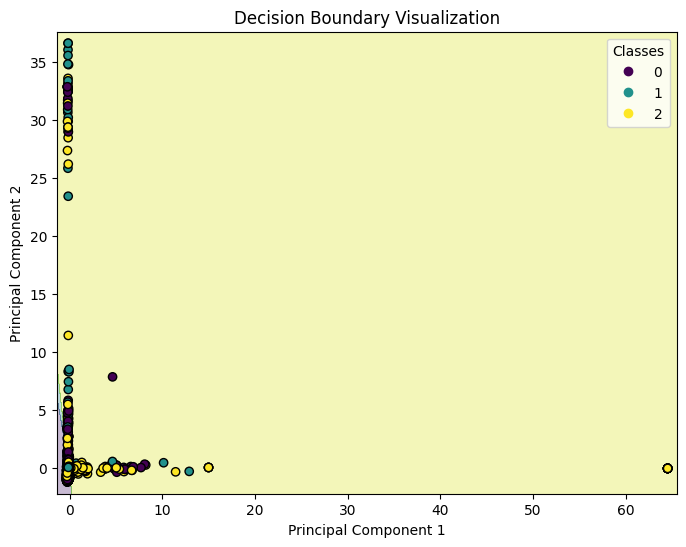

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf.toarray())

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Train the model on the reduced feature space
final_linear_svm_model.fit(X_train_pca, y_train)

# Plot the decision boundary and data points
plt.figure(figsize=(8, 6))

# Create a grid of points to visualize the decision boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict class labels for the grid points
Z = final_linear_svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)

# Plot the data points
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary Visualization')
plt.show()